In [127]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import time
import copy
import random
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, join
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.time import Time
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground
from photutils.utils import make_random_cmap
import astroalign as aa
import pickle

### Functions:

In [2]:
# could add a check to see if apertures need to be plotted (in case i want to plot just the fits)
def plotting(region, ap, an, cmap, choice, savename):
    plt.imshow(region, cmap=cmap, origin='lower', norm=LogNorm(), interpolation='nearest')
    
    if choice == 'ap_only':
        ap.plot(color='blue', lw=.5, alpha=1.)
    elif choice == 'both_aps':
        ap.plot(color='blue', lw=.5, alpha=.5)
        an.plot(color='red', lw=.5, alpha=.5)
        
    plt.colorbar(fraction = 0.05)
    #plt.grid(True)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    
    if savename != None:
        plt.savefig('images/'+savename, dpi=500)
    
    plt.gcf().set_size_inches(10, 6)
    plt.show()
    #plt.close()
    
def print_table_nicely(table):   # note: 'table' must be an astropy Table type
    for col in table.colnames:
        table[col].info.format = '%.8g'
    print(table)
    
def star_find(data, sigma, fwhm, std, roundness, sharphi):
    daofind = DAOStarFinder(threshold=sigma*std, fwhm=fwhm, roundlo=-roundness, roundhi=roundness, sharphi=sharphi)
    sources = daofind(data)
    return sources
    
def ap_phot(data, ap, an, bkg_method):
    all_apers = [ap, an]
    table = aperture_photometry(data, all_apers)
    
    if bkg_method == 'mean':
        bkg_mean = table['aperture_sum_1'] / an.area
        table['bkg_sum_mean'] = bkg_mean * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_mean']
        
        an_err = bkg_mean * ap.area / np.sqrt(an.area)
        ap_err = bkg_mean * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
    
    elif bkg_method == 'median':
        annulus_masks = an.to_mask(method='center')
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_mask, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_mask)
            
        bkg_median = np.array(bkg_median)
        table['bkg_sum_median'] = bkg_median * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_median']
        
        an_err = bkg_median * ap.area / np.sqrt(an.area)
        ap_err = bkg_median * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
        
    else:
        print('\n\nPlease give a valid bkg_method kthx\n\n')
            
    return table

def apparent_magnitude_err(counts, apcorr, zmag_err, counts_err, apcorr_err):
    mag_err = np.sqrt(zmag_err**2 + (2.5 * np.sqrt((counts_err/counts)**2 + (apcorr_err/apcorr)**2) / np.log(10))**2)
    return mag_err

def make_catalog(x, y, header):
    crd = np.transpose((x, y))
    w = wcs.WCS(header)
    world = w.wcs_pix2world(crd, 0)
    ra = world[:,0]
    dec = world[:,1]
    cat = SkyCoord(ra, dec, frame='icrs', unit='deg')
    
    return cat, ra, dec

### Initial conditions:

In [197]:
run_all = True  # set to False to run only the first epoch
base_dir = 'data/PAL5/'
channel = '3p6um'
#channel = '4p5um'
#method = 'aperture'
method = 'PSF'
model_epoch = 'master'  # ePSF model epoch to use (loads from file now for ease)

sigma_level = 6.
sigma_level_PSF = 50.
FWHM = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundness = 0.5
sharphi = 0.9
sharphi_PSF = 0.7
#sharplo = 0.65

if channel == '3p6um':
    zmag       = 18.80    # given in/calculated using IRAC handbook, section 4.8
    zmag_err   =  0.02    # calculated from zmag = 2.5log10(F0/C), F0 = 280.9 +/- 4.1 (from IRAC, table 4.1)
    apcorr     =  1.1233  # aperture correction for 6, 6-14 pix apertures in channel 1; given on IRAC website
    apcorr_err =  0.0225  # taking accuracy to be ~2%, as mentioned in IRAC, section 4.10
elif channel == '4p5um':
    zmag       = 18.32
    zmag_err   =  0.02
    apcorr     =  1.1336
    apcorr_err =  0.0227
else:
    print('Please select a valid channel')

### Generating master source list:

data/PAL5/PAL5/PAL5_4p5um.fits


No. of stars detected: 817


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


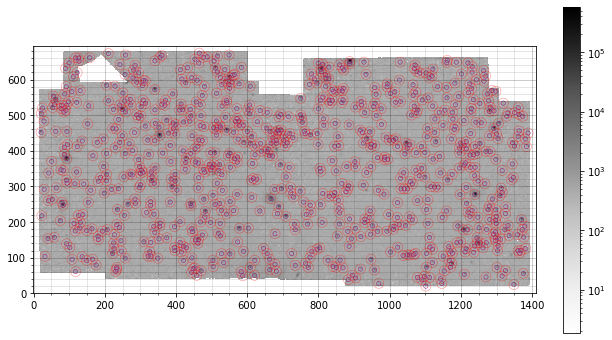

id_master     xcentroid      ...         RA                 dec         
--------- ------------------ ... ------------------ --------------------
        0 1101.5124302933175 ... 229.05374172358637 -0.24168129917280076
        1 1348.7797423589093 ...  229.0462654350521 -0.28221599639427997
        2  1146.344447826931 ... 229.05131430565655 -0.24885250909690815
        3  969.3359075931846 ... 229.05609666372123 -0.21974067923658724
        4   883.963587498637 ... 229.05667335971907 -0.20541236408427022
        5 1090.3554984127047 ... 229.05116016782713 -0.23936723929054277
        6 1142.5676041792424 ... 229.04926575335497 -0.24787393841307775
        7  904.2534054547654 ... 229.05539373924321 -0.20862778643936858
        8 1077.7998844146452 ...  229.0503392403781 -0.23710946470297498
        9   1112.02287681418 ... 229.04944704766922 -0.24274336154949952
      ...                ... ...                ...                  ...
      806 118.40107584742384 ...  228.9752436582047

In [179]:
file_m = base_dir+'PAL5/PAL5_'+channel+'.fits'
with fits.open(file_m) as hdu_list:        
    print(file_m)
    image_m = hdu_list[0].data
    hdr_m = hdu_list[0].header
    exptime = hdr_m['EXPTIME']
    fluxconv = hdr_m['FLUXCONV']
    conv = exptime / fluxconv
    data_m = image_m * conv

mean_m, median_m, std_m = sigma_clipped_stats(data_m, sigma=sigma_level)

sources_m = star_find(data_m, sigma_level, FWHM, std_m, roundness, sharphi)
pos_m = np.transpose((sources_m['xcentroid'], sources_m['ycentroid']))
apertures_m = CircularAperture(pos_m, r_ap)
annuli_m = CircularAnnulus(pos_m, r_in, r_out)
print('No. of stars detected: {}'.format(len(sources_m)))
plotting(data_m, apertures_m, annuli_m, 'Greys', choice='both_aps', savename=None)

sources_m['id'] -= 1
sources_m['id'].name = 'id_master'

cat_m, ra_m, dec_m = make_catalog(sources_m['xcentroid'], sources_m['ycentroid'], hdr_m)
sources_m['RA'] = ra_m
sources_m['dec'] = dec_m

print(sources_m)
#sources_m.write('outputs/table_'+channel+'_master''.txt', format='csv', overwrite=True)
sources_m['xcentroid', 'ycentroid', 'RA', 'dec'].write('outputs/master_list_test.txt', format='csv', overwrite=True)

### Identifying Christine's stars in my source lists:

In [72]:
file_CC = 'data/reference/CVSGC_PAL5_readable.txt'
df_CC = pd.read_csv(file_CC, sep=',', header=0)
coord_CC = SkyCoord(df_CC['RA'], df_CC['dec'])
c_comp = SkyCoord(comp_table['RA']*u.degree, comp_table['dec']*u.degree)

desired_star = 4  # note: 0,2,4 only ones visible in channel 1
c_CC = coord_CC[desired_star]
print(c_CC)

#print(df_CC)
#print(c_CC[0].ra.deg, c_CC[0].dec.deg)
#print(c_comp.ra.deg)
#print(len(c_comp), len(comp_table))

#near_coord, near_idx = find_nearest(comp_table['RA'], c_CC.ra.deg)
#ra_near, dec_near, idx_ra, idx_dec = find_nearest_2d(comp_table['RA'], comp_table['dec'], c_CC.ra.deg, c_CC.dec.deg)

start = time.perf_counter()

seps = []
for i in range(len(c_comp)):
    seps.append(c_comp[i].separation(c_CC).value)

print('Time taken to calculate all separations: {}s'.format(time.perf_counter() - start))

id_good = np.asarray(seps).argmin()
print(id_good)

seps = np.array(seps)
print(seps.argmin(), seps[seps.argmin()])
comp_table[:][seps.argmin()]

<SkyCoord (ICRS): (ra, dec) in deg
    (228.992625, -0.0965)>
Time taken to calculate all separations: 0.4644900000002963s
351
351 5.440460584975601e-05


<Row index=351>
id_master     xcentroid        ycentroid             RA                dec                mag_e1              err_e1             mag_e2              err_e2             mag_e3             err_e3             mag_e4              err_e4             mag_e5             err_e5             mag_e6             err_e6             mag_e7             err_e7             mag_e8             err_e8             mag_e9            err_e9            mag_e10            err_e10            mag_e11             err_e11      
  int32        float64          float64           float64            float64             float64             float64            float64             float64            float64            float64            float64             float64            float64            float64            float64            float64            float64            float64            float64            float64            float64           float64            float64            float64            float64             float64      
--------- ----------------- ---------------- ----------------- -------------------- ------------------ ------------------- ------------------ ------------------- ------------------ ------------------ ------------------ ------------------- ------------------ ------------------ ----------------- ------------------- ----------------- ------------------- ----------------- ------------------- ----------------- ------------------ ----------------- ------------------- ------------------ -------------------
      615 982.8027459818385 503.180117564998 228.9926746120823 -0.09652232732423885 16.341757883504528 0.12490531888600374 16.363346683880508 0.10726810792787739 16.356868998845314 0.1079286445580241 16.352587784735846 0.10071449872458513 16.301941781453646 0.0986811049570592 16.43447125230149 0.08865384931581587 16.38766118029609 0.11215511874315458 16.46038054986956 0.08026159600643352 16.41409560418427 0.0681620353316304 16.29592913306142 0.08788980946784694 16.372069644250296 0.08090984170752949

### Building an ePSF from one image:

File to build ePSF model from: data/PAL5/PAL5/PAL5_4p5um.fits


    x         y      id
--------- --------- ---
947.63254 95.375688   0
551.35598 110.67748   1
222.06994 111.59022   2
1214.6168 125.48499   3
374.22394  155.9409   4
181.25231  160.4009   5
1207.2888 178.35193   6
1191.5682 189.15935   7
951.14108 189.80531   8
75.292469 204.03903   9
      ...       ... ...
664.21711 454.50907  48
694.85049 458.73542  49
 1292.352 463.25877  50
313.82935 469.75598  51
1305.8121 476.87588  52
752.59024 492.80049  53
 1279.708 510.89894  54
249.39411 516.63395  55
 750.2157 547.61649  56
340.71134 572.02089  57
256.94365 614.55838  58
Length = 59 rows
Number of model stars: 59


C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


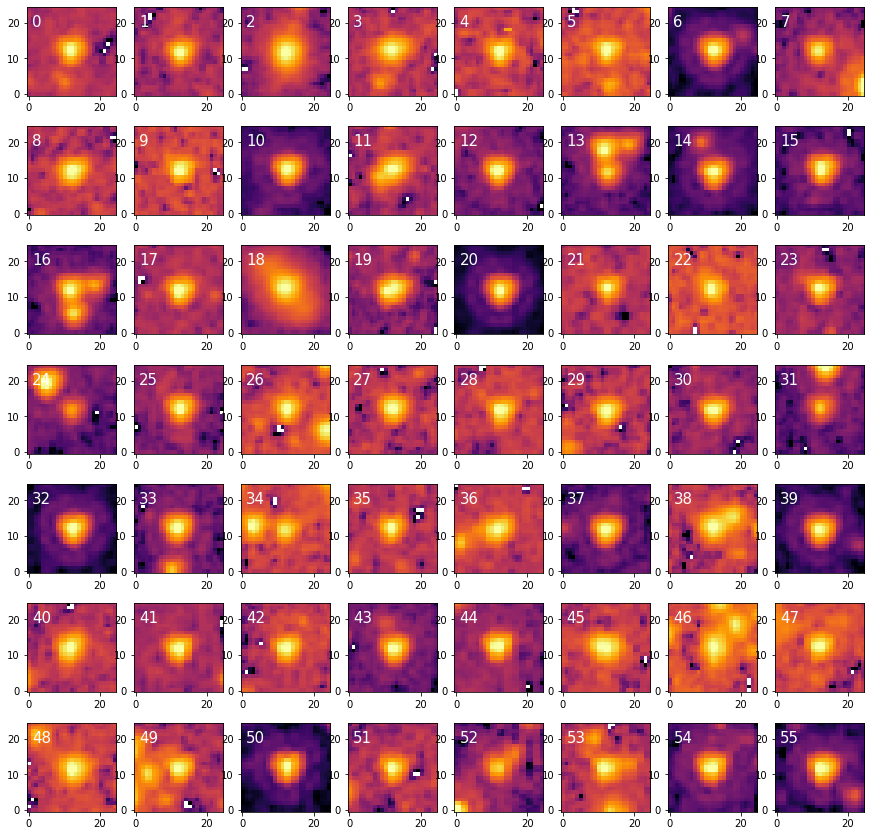

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


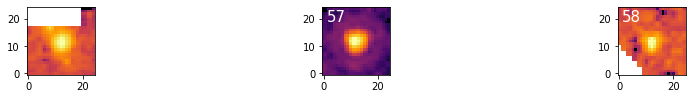

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


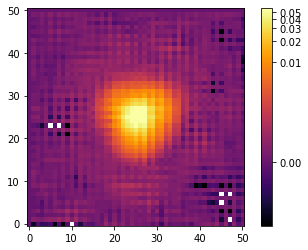

Input bad stars to remove them from the model (type -1 to exit simulation and save model):
3 11 13 14 16 18 19 24 26 31 33 34 38 46 48 49 52 53 55 56 58
[3, 11, 13, 14, 16, 18, 19, 24, 26, 31, 33, 34, 38, 46, 48, 49, 52, 53, 55, 56, 58]
    x         y      id
--------- --------- ---
947.63254 95.375688   0
551.35598 110.67748   1
222.06994 111.59022   2
374.22394  155.9409   4
181.25231  160.4009   5
1207.2888 178.35193   6
1191.5682 189.15935   7
951.14108 189.80531   8
75.292469 204.03903   9
482.39858 230.30657  10
      ...       ... ...
1253.5676 420.83827  40
608.97162 421.63059  41
242.12887 423.83341  42
1129.2287 425.62373  43
612.72068 440.35814  44
777.66683 445.00856  45
561.90827 452.33035  47
 1292.352 463.25877  50
313.82935 469.75598  51
 1279.708 510.89894  54
340.71134 572.02089  57
Length = 38 rows
Number of model stars: 38


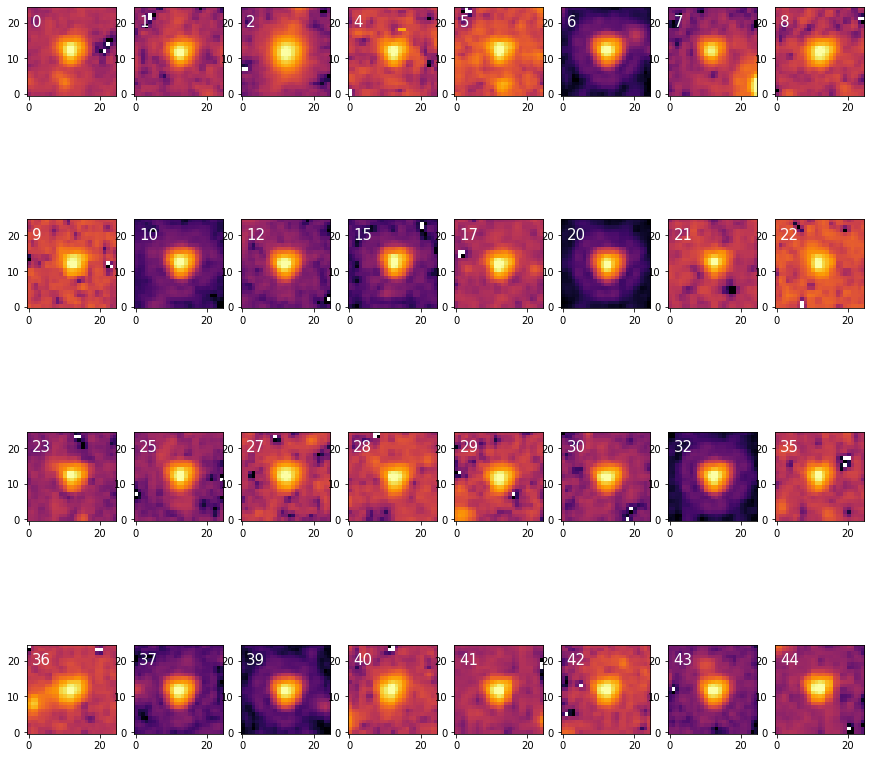

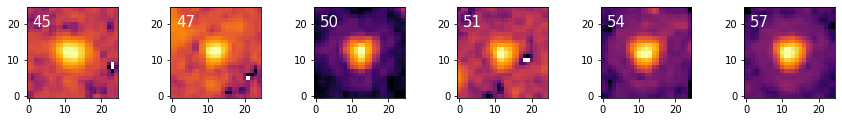

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


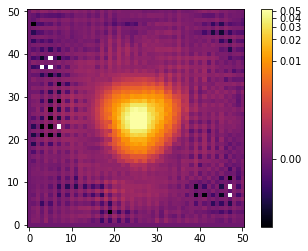

Input bad stars to remove them from the model (type -1 to exit simulation and save model):
-1
[-1]
Congrats Phil Collins, you escaped


In [170]:
###   BUILDING AN EPSF MODEL FROM ONE IMAGE   ###    

which_epoch = 'master'   # set to 'master' to build model from medianed image

if which_epoch == 'master':
    file_model = base_dir+'PAL5/'+'PAL5_'+channel+'.fits'
else:
    file_model = base_dir+'PAL5__e'+str(which_epoch)+'/PAL5__e'+str(which_epoch)+'_'+channel+'.fits'

print('File to build ePSF model from: {}'.format(file_model))
with fits.open(file_model) as hdu_list:
    data_model = hdu_list[0].data
    hdr_model = hdu_list[0].header
    data_model *= hdr_model['EXPTIME'] / hdr_model['FLUXCONV']

###   LOCATING STARS FOR PSF MODEL AND PLOTTING THEM   ###

mean, median, std = sigma_clipped_stats(data_model, sigma=sigma_level)

sources_model = star_find(data_model, sigma_level_PSF, FWHM, std, roundness, sharphi_PSF)
pos_model = np.transpose((sources_model['xcentroid'], sources_model['ycentroid']))
ap_model = CircularAperture(pos_model, r_ap)
an_model = CircularAnnulus(pos_model, r_in, r_out)
#print('No. of stars detected to build model from: {0}'.format(len(sources_model)))
#plotting(data_model, ap_model, an_model, 'Greys', choice='both_aps', savename=None)

###   DOING APERTURE PHOTOMETRY ON MODEL STARS   ###

phot_table = ap_phot(data_model, ap_model, an_model, 'median')
#print_table_nicely(phot_table)

cutout_size = 150
hsize = (cutout_size - 1) / 2
x_model = phot_table['xcenter'].value
y_model = phot_table['ycenter'].value
mask = ((x_model > hsize) & (x_model < (data_model.shape[1] - 1 - hsize)) &
        (y_model > hsize) & (y_model < (data_model.shape[0] - 1 - hsize)))
model_table = Table()
model_table['x'] = x_model[mask]
model_table['y'] = y_model[mask]

# Just numberin' the stars, don't mind me
model_table['id'] = np.array(range(len(model_table)))
print_table_nicely(model_table)

pos_model = np.transpose((model_table['x'], model_table['y']))
ap_model = CircularAperture(pos_model, r_ap)
#plotting(data_model, ap_model, an=None, cmap='Greys', choice='ap_only', savename=None)

while True:
    
    ###   BUILDING AN EPSF   ###

    nddata = NDData(data = data_model - median)
    model_stars = extract_stars(nddata, model_table, size=25)
    print('Number of model stars: {}'.format(len(model_stars)))
    figsize = 15
    ncols = 8
    nrows = int(np.floor(len(model_stars) / ncols))
    nremainder = len(model_stars) - (nrows*ncols)
    
    # Show images of most of the stars in a nice grid:
    fig, ax = plt.subplots(nrows, ncols, figsize=(figsize,figsize), squeeze=True)
    ax = ax.ravel()        
    for i in range(nrows*ncols):
        norm = simple_norm(model_stars[i], 'log', percent=99.)
        ax[i].imshow(model_stars[i], norm=norm, origin='lower', cmap='inferno', interpolation='nearest')
        #ax[i].set_title(model_table['id'][i])
        ax[i].text(1, 19, model_table['id'][i], color='w', size=15)
    plt.show()
    
    # Show images of the remaining stars that don't fit in the grid:
    fig, ax = plt.subplots(nrows=1, ncols=nremainder, figsize=(figsize,figsize/(figsize-nremainder)), squeeze=False)
    ax = ax.ravel()
    for i in range(nrows*ncols, len(model_stars)):
        norm = simple_norm(model_stars[i], 'log', percent=99.)
        ax[i-nrows*ncols].imshow(model_stars[i], norm=norm, origin='lower', cmap='inferno', interpolation='nearest')
        #ax[i-nrows*ncols].set_title(model_table['id'][i])
        ax[i-nrows*ncols].text(1, 19, model_table['id'][i], color='w', size=15)
    plt.show()

    epsf_builder = EPSFBuilder(oversampling=2, maxiters=10, progress_bar=True)
    epsf, fitted_stars = epsf_builder(model_stars)
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='inferno')
    plt.colorbar()
    plt.show()

    print('Input bad stars to remove them from the model (type -1 to exit simulation and save model):')
    adios = [int(x) for x in input().split()]
    print(adios)

    if adios == [-1]:
        print('Congrats Phil Collins, you escaped')
        
        save_name = 'epsf_models/epsf_'+channel+'_'+str(which_epoch)+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(epsf, pickle_out)
        pickle_out.close()
        
        break

    #model_table.remove_rows(adios)
    
    # Remove bad stars from the table:
    model_table.add_index('id')
    byebye = model_table.loc_indices[adios]
    model_table.remove_rows(byebye)

    print_table_nicely(model_table)

### Main photometry code:

Photometry method selected: aperture


C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


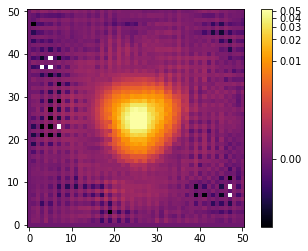

data/PAL5\PAL5__e1\PAL5__e1_4p5um.fits
EXPTIME: 81.4431
FLUXCONV: 0.1447


Mean: 44.101036071777344
Median: 42.89814376831055
Std dev: 13.552461624145508
No. of stars detected: 545


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


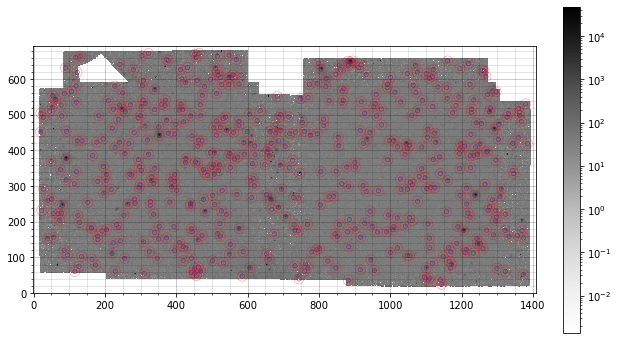

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag   mag_err  
       pix       pix                                                   
--- --------- --------- ----------- ---------- ------------ -----------
  1 1144.5399 24.854201         nan        nan          nan         nan
  2  882.2909 36.005182   1972.8833  506.72386    16.812949  0.28042553
  3  1106.997 36.662134   1500.6513  535.30924    17.103263  0.38842657
  4 1140.4175 37.684209   1294.3212  488.50228    17.281522  0.41084165
  5 744.48467 39.806977         nan        nan          nan         nan
  6 1109.6827 41.697305   1393.4898   517.6794    17.198371  0.40442975
  7 1095.9628 45.167765   1779.6732  549.98962    16.930152   0.3368335
  8 585.06859 47.504311         nan        nan          nan         nan
  9 456.42435 49.111055   364.18966  524.54763    18.643411   1.5640806
 10 1373.0963 52.639203   9661.1364  502.78064    15.130344  0.06375994
...       ...       ...         ...        ...          ...     

No. of stars detected: 564


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


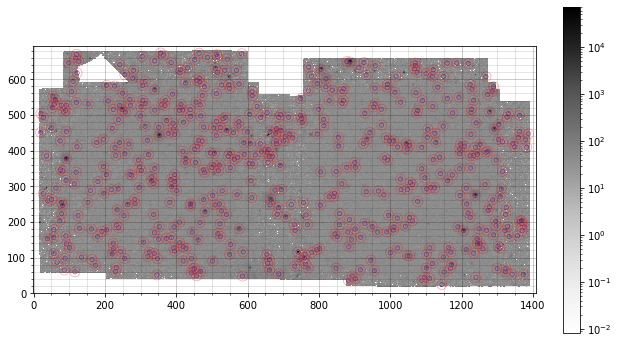

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag   mag_err  
       pix       pix                                                   
--- --------- --------- ----------- ---------- ------------ -----------
  1 1144.9457 24.567983         nan        nan          nan         nan
  2 1088.8955 34.676884   904.48736  540.84256    17.652503  0.64989294
  3 882.51748 35.908934     1288.23   526.3674    17.276343  0.44461147
  4 902.43913 40.292259   1424.0602   523.1289    17.165043  0.39993802
  5 1110.1888 41.720154   1719.9507  496.84742    16.970166   0.3150281
  6 1096.2309 45.084921   1659.8176  542.73922     17.00615  0.35624886
  7 1240.3962 44.671493  -27.446829        nan          nan         nan
  8 586.34316 47.972803   956.54855  627.54496    17.614491  0.71291102
  9 893.28418 48.357101   856.37836  513.32089    17.716451  0.65147018
 10 457.12409 48.670118   798.85348  536.21051    17.790933  0.72937189
...       ...       ...         ...        ...          ...     

No. of stars detected: 550


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


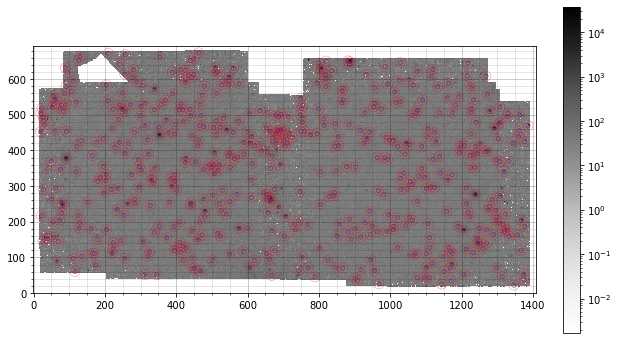

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag  mag_err  
       pix       pix                                                  
--- --------- --------- ----------- ---------- ------------ ----------
  1 1346.7509 22.447788         nan        nan          nan        nan
  2 1144.4618 25.286524   2158.7993  458.85166    16.713378 0.23265579
  3 968.28399 25.690913   1727.8064  467.20633    16.953709 0.29507029
  4 1170.7755 34.117737  -400.82737        nan          nan        nan
  5 909.29517 36.193983     942.327  478.65427    17.613752  0.5522895
  6 1375.6315 37.172736  -1961.7521        nan          nan        nan
  7 902.67012 41.469862   771.77793  510.90452    17.829927 0.71934667
  8 1075.8361 42.961239    188.1712  487.81267    19.367722   2.814804
  9 1110.4462 43.059436   1230.0324  506.84796    17.333924 0.44836345
 10   789.783 45.544296    876.0211  545.35462    17.690346 0.67655507
...       ...       ...         ...        ...          ...        ...
541  8

No. of stars detected: 562


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


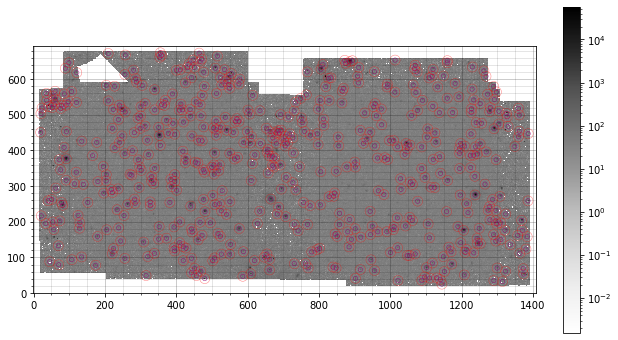

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag   mag_err  
       pix       pix                                                   
--- --------- --------- ----------- ---------- ------------ -----------
  1 1144.9417 25.195736         nan        nan          nan         nan
  2 1314.7389 32.381279  -551.25785        nan          nan         nan
  3 1290.6808 35.201137   983.95689  434.75078    17.589687  0.48062961
  4 1021.9917 35.321941   482.31591   486.5942    18.340034   1.0957653
  5 1088.5127 35.668281    1166.838  529.20334    17.384765  0.49330605
  6   1140.79 37.962458   1628.3109  443.66065    17.026815   0.2972984
  7 902.73793 41.317256   1060.5653  500.66125    17.484965  0.51339431
  8 480.05272 40.729618         nan        nan          nan         nan
  9 1110.4698 42.242767   1711.2595  484.58998    16.975704   0.3088719
 10 1130.1648 42.571244   -23.61295        nan          nan         nan
...       ...       ...         ...        ...          ...     

No. of stars detected: 546


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


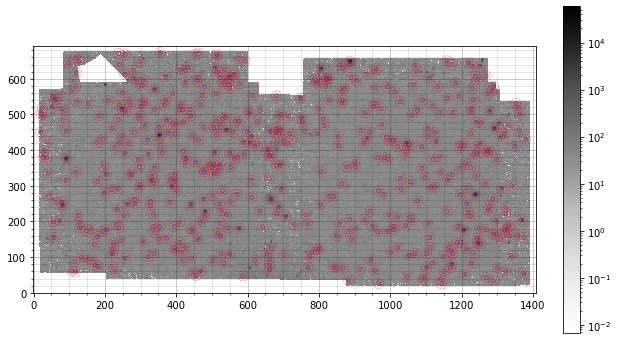

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag  mag_err  
       pix       pix                                                  
--- --------- --------- ----------- ---------- ------------ ----------
  1 1144.7818 25.000635         nan        nan          nan        nan
  2 968.19393 25.704694   1476.7972  538.33524    17.124257 0.39688317
  3 1089.0207 35.271465   570.41199  544.45781    18.162901  1.0367553
  4 1290.4825 34.909901   1153.3872  426.29263    17.417396  0.4023747
  5  882.6489 36.144941   1646.8683  517.59379    17.009252 0.34251208
  6 1141.1626 37.892305   1175.4603   464.6284     17.38228 0.43017839
  7 1268.9094 43.938903   905.32141  451.47156    17.673937 0.54224728
  8  1047.444 45.741518   768.88069  469.77382    17.836129 0.66402493
  9 1096.3893 45.262645   1744.1451  544.80672    16.952481 0.34042819
 10 587.09762 47.189328   618.58624  657.13237    18.087967  1.1537702
...       ...       ...         ...        ...          ...        ...
537 11

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


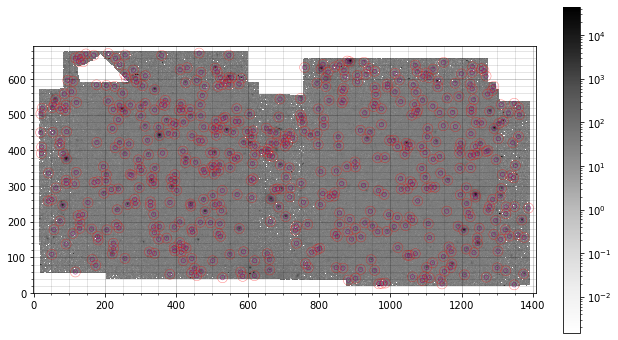

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag   mag_err  
       pix       pix                                                   
--- --------- --------- ----------- ---------- ------------ -----------
  1 1347.7233 23.238973         nan        nan          nan         nan
  2  968.1378 26.062758   41594.603   495.3921    13.499922 0.032247616
  3  1145.256 25.875263   1933.3052  408.44023    16.833337  0.23127282
  4 976.21854 26.868677         nan        nan          nan         nan
  5 986.34408 28.193018         nan        nan          nan         nan
  6 1089.8918 35.604196   991.47171  522.31262     17.56302  0.57273404
  7 882.55064 36.637414     1056.86  497.12563    17.490912  0.51156209
  8  1140.981 39.562781   1122.0667  414.94797    17.439465  0.40259799
  9 902.90942 41.635141   1084.5516  494.93248    17.460704  0.49635294
 10 1109.7239 43.011871   1626.2654  505.93379    17.030684  0.33906365
...       ...       ...         ...        ...          ...     

No. of stars detected: 539


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


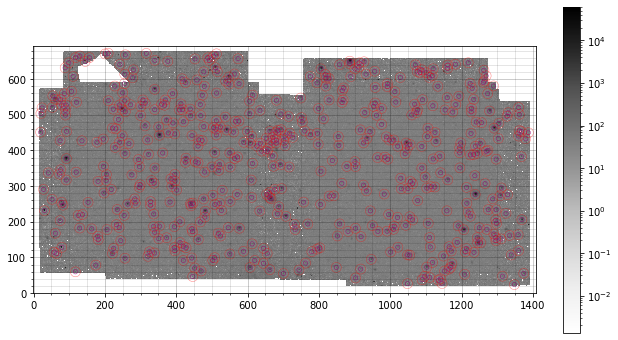

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag  mag_err  
       pix       pix                                                  
--- --------- --------- ----------- ---------- ------------ ----------
  1 1348.1454 23.918322         nan        nan          nan        nan
  2 1048.3954 26.532582   214.34784  459.80937    19.216506  2.3292599
  3 1145.4016 26.975264   1650.4269  506.37421    17.005003 0.33442648
  4 1135.2322 36.313501  -241.62062        nan          nan        nan
  5 1089.3884 37.428482   467.92597   555.5785    18.381345  1.2894562
  6 1141.7016 39.912601   955.65519  464.73547    17.613901  0.5288197
  7 903.01773 42.514571   881.22181  519.24673    17.685933 0.64043546
  8 1110.9819 43.888546   1542.6644  466.40423    17.088228 0.32958463
  9 446.41913 46.477799  -1383.0971        nan          nan        nan
 10  1097.034 47.284408   1918.2297  527.49997    16.849101 0.30002788
...       ...       ...         ...        ...          ...        ...
530  1

No. of stars detected: 542


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


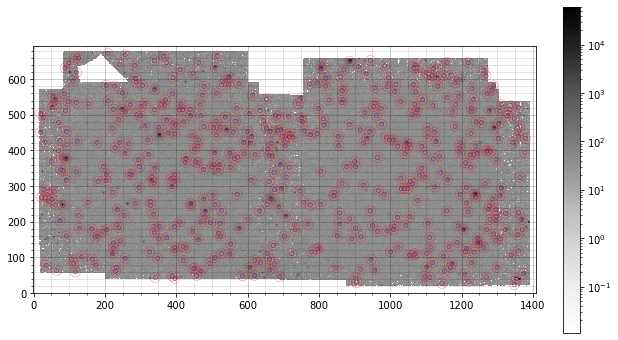

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])
WARNING

 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag   mag_err  
       pix       pix                                                   
--- --------- --------- ----------- ---------- ------------ -----------
  1 1348.0835 24.070732         nan        nan          nan         nan
  2 1145.2521 26.879144    1815.457  466.10787    16.901656  0.28031733
  3 906.38292 29.774328  -1333.7565        nan          nan         nan
  4 1220.2954 32.911364  -171.09145        nan          nan         nan
  5   396.831 41.316354         nan        nan          nan         nan
  6 903.02706 41.971359   640.16468  540.07686      18.0332  0.91646086
  7 1354.6296 41.709971    226016.1  655.41742    11.703598 0.029708714
  8  341.3885 43.888919         nan        nan          nan         nan
  9 1111.3735 44.181476   1355.3372  502.06406    17.228811  0.40327794
 10  1269.633 45.458751   -26.80862        nan          nan         nan
...       ...       ...         ...        ...          ...     

: Input data contains invalid values (NaNs or infs), which were automatically clipped. [astropy.stats.sigma_clipping]


No. of stars detected: 566


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


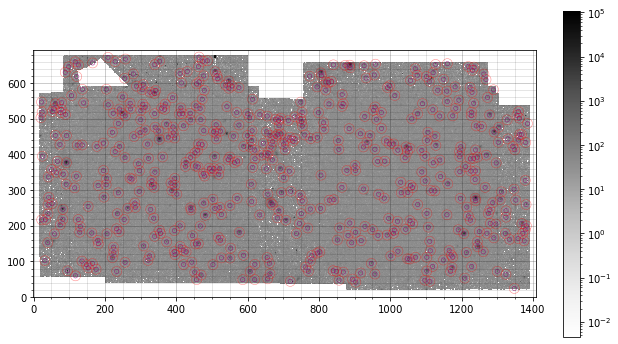

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag  mag_err  
       pix       pix                                                  
--- --------- --------- ----------- ---------- ------------ ----------
  1 1347.9959 24.320312         nan        nan          nan        nan
  2 903.61551 41.924677   889.78458   521.4463    17.675862 0.63696652
  3 719.70346 44.124864   132.42517  650.49553    19.750094  5.3334075
  4  1111.248  44.42033   1487.4253  486.90334    17.127893 0.35663746
  5 856.46977 47.380141   10.531357  550.21104    22.487561  56.724329
  6 1097.2239  47.53606   1656.9106   529.3747    17.008212 0.34814295
  7 586.68885 48.963863   684.04102  651.12312    17.978771  1.0339098
  8 620.10362 49.205138   4143.7982  797.84432    16.030467 0.21112397
  9 457.52817 49.185339   960.42321  491.89833    17.591094  0.5568638
 10 894.12144 50.465366   653.55939  488.66231    18.009742 0.81233557
...       ...       ...         ...        ...          ...        ...
557  1

No. of stars detected: 556


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


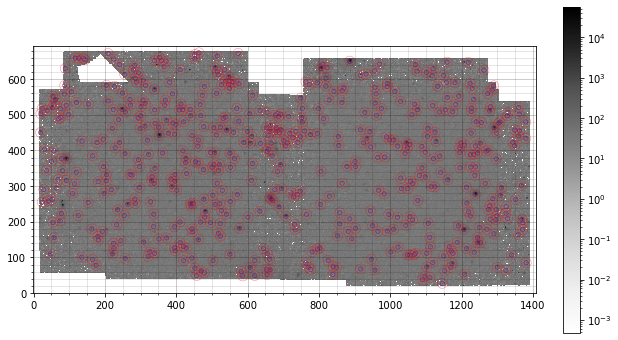

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag  mag_err  
       pix       pix                                                  
--- --------- --------- ----------- ---------- ------------ ----------
  1 1145.7866  27.32101   2043.2841  459.22577     16.77297 0.24579965
  2 1089.9508 37.257825   1168.1907  485.51927    17.387959 0.45221578
  3 1111.3447 43.864121   1031.5298  478.30677    17.525253 0.50430757
  4 586.45357 48.146244   843.45276  617.39003    17.751129 0.79528537
  5 1097.5076 47.560199   1619.5566  509.39864    17.032817 0.34277164
  6 457.64847 49.244246   879.06268  498.38718    17.687085  0.6162698
  7 620.24498 49.411241   4613.7402  771.58822    15.913686 0.18396273
  8 839.38314 51.714924  -643.23351        nan          nan        nan
  9 654.74575 51.722616   438.63596  711.07736    18.477021  1.7603462
 10 1209.2814 53.214066    4651.055  442.14592    15.884595 0.10735836
...       ...       ...         ...        ...          ...        ...
547 45

No. of stars detected: 547


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


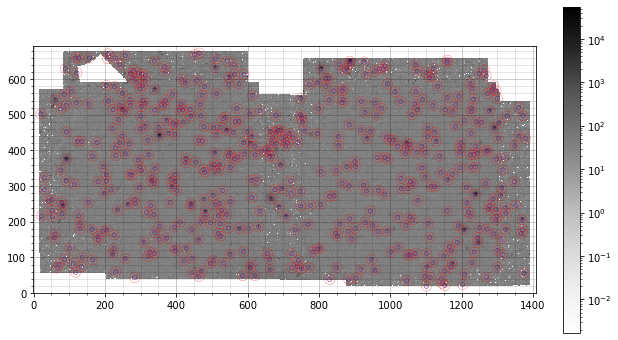

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag  mag_err  
       pix       pix                                                  
--- --------- --------- ----------- ---------- ------------ ----------
  1 1101.5058 19.582608         nan        nan          nan        nan
  2 1153.0051 21.339225         nan        nan          nan        nan
  3 1203.6237 23.704711         nan        nan          nan        nan
  4  1146.115 27.080223   1499.0739    445.811     17.10925 0.32423669
  5 1046.4975 34.515354   318.43931  464.47623    18.785331  1.5839326
  6 830.52413 38.093838         nan        nan          nan        nan
  7 883.68652 37.773671   1456.1457  489.12286     17.14274 0.36589592
  8 1142.5859 40.264872   1757.1626  427.28061    16.952645 0.26566075
  9 904.37336 42.171125   375.20454  513.14297    18.612823   1.485185
 10 284.13859 43.516912         nan        nan          nan        nan
...       ...       ...         ...        ...          ...        ...
538 50

No. of stars detected: 555


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


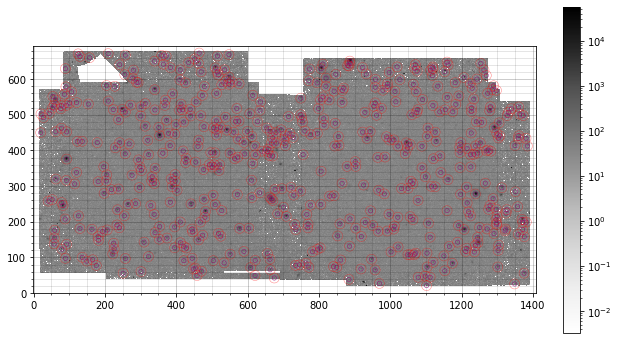

<ipython-input-2-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag   mag_err  
       pix       pix                                                   
--- --------- --------- ----------- ---------- ------------ -----------
  1 1102.0242 21.014391         nan        nan          nan         nan
  2 1348.8529 25.704786         nan        nan          nan         nan
  3 969.58943 27.080542   1290.3698   494.7426    17.270764   0.4173306
  4 884.28397 38.289893   728.47619  500.97781    17.894668    0.747252
  5 675.09838 42.438403         nan        nan          nan         nan
  6 1078.6033 44.605206   649.77847  437.74458    18.022681  0.73203811
  7  1112.087 44.615426    1240.195  460.76684    17.325593  0.40446141
  8  1098.115 47.651618   2231.9073  477.88698    16.685037  0.23434291
  9 458.55073 49.332652         nan        nan          nan         nan
 10 621.11735 49.379398         nan        nan          nan         nan
...       ...       ...         ...        ...          ...     

In [180]:
print('Photometry method selected: {}'.format(method))

###   INITIALISING IMAGE WE'LL BE COMPARING OTHER EPOCHS TO WHEN STAR MATCHING   ###

epoch = 1  # counter to be incremented every epoch
LC_time = []

huge_table = copy.copy(sources_m['id_master', 'xcentroid', 'ycentroid', 'RA', 'dec'])

epsf_file = 'epsf_models/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='inferno')
plt.colorbar()
plt.show()

for filename in glob.glob(base_dir+'*/PAL5__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/PAL5__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    
    #filename = base_dir+'PAL5__e8/PAL5__e8_3p6um.fits'
    #print(filename)
    
    ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###
    
    with fits.open(filename) as hdu_list:        
        print(filename)
        image_data = hdu_list[0].data
        hdr = hdu_list[0].header
        exptime = hdr['EXPTIME']
        fluxconv = hdr['FLUXCONV']
        conv = exptime / fluxconv
        print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
        data = image_data * conv
    
    file_corr = base_dir+'PAL5__e'+str(epoch)+'/PAL5__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(file_corr) as hdu_list:
        data_corr = hdu_list[0].data
    
    LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)
        
    mean, median, std = sigma_clipped_stats(data, sigma=sigma_level)
    print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))
    
    
    
    if method == 'aperture':
    
        ###   LOCATING STARS AND PLOTTING THEM   ###
        # could maybe put most of this in its own starfind function? including aperture and position bits

        sources = star_find(data, sigma_level, FWHM, std, roundness, sharphi)
        #sources = star_find(data, 300., FWHM, std, roundness, sharphi)
        pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(pos, r_ap)
        annuli = CircularAnnulus(pos, r_in, r_out)
        print('No. of stars detected: {0}'.format(len(sources)))
        plotting(data, apertures, annuli, 'Greys', choice='both_aps', savename=None)
        
        #starlist = np.array(sources['xcentroid', 'ycentroid'])
        #np.savetxt('outputs/starlist_02.txt', starlist, delimiter=',')

        ###   DOING APERTURE PHOTOMETRY   ###

        phot_table = ap_phot(data, apertures, annuli, 'median')
        
        phot_table['apparent_mag'] = float('NaN')
        phot_table['mag_err'] = float('NaN')
        for i in range(len(phot_table)):
            locorr = data_corr[int(phot_table['ycenter'][i].value)][int(phot_table['xcenter'][i].value)]  # location-dependent correction at star's location
            if phot_table['star_bkgsub'][i] >= 0:
                phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)
        
        phot_table.write('outputs/table_'+channel+'_e'+str(epoch)+'.txt', format='csv', overwrite=True)
        #print_table_nicely(phot_table)
        print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])
        
        match_table = copy.copy(phot_table)
        del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
        mag_name = 'mag_e'+str(epoch)
        err_name = 'err_e'+str(epoch)
        match_table.rename_column('apparent_mag', mag_name)
        match_table.rename_column('mag_err', err_name)
        
        


    
    elif method == 'PSF':
        
        ###   DETECTING MORE STARS   ###
        
        daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=0.85)
        sources_PSF = daofind_PSF(data)
        
        sources_PSF['xcentroid', 'ycentroid'].write('outputs/epoch_'+str(epoch)+'_list_test.txt', format='csv', overwrite=True)
        
        #sources_PSF = star_find(data, sigma_level, FWHM, std, roundness, sharphi)
        pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
        ap_PSF = CircularAperture(pos_PSF, r_ap)
        #plotting(data, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename='psf_detect_test_00.png')
        print('Number of PSF stars: {}'.format(len(sources_PSF)))
        
        ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###
        
        sources_PSF['xcentroid'].name = 'x_0'
        sources_PSF['ycentroid'].name = 'y_0'
        daogroup = DAOGroup(crit_separation=2.5*FWHM)
        #daogroup = DAOGroup(crit_separation=4*FWHM)
        star_groups = daogroup(sources_PSF)
        star_groups = star_groups.group_by('group_id')
        print_table_nicely(star_groups)
        
        ncolors = max(star_groups['group_id'])
        cmap = make_random_cmap(ncolors=ncolors, seed=1612)
        plt.imshow(data, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
        for i, group in enumerate(star_groups.groups):
            pos_group = np.transpose([group['x_0'], group['y_0']])
            ap_group = CircularAperture(pos_group, r_ap)
            ap_group.plot(color=cmap.colors[i], lw=1.)
        plt.gcf().set_size_inches(15, 9)
        plt.show()
        
        ###   ALIGNING MASTER STAR POSITIONS WITH EPOCH FRAME   ###
        # currently not using this part, but i've left it just in case i revert back
        
        transf, (src_list, trg_list) = aa.find_transform(data_m, data)
        #master_xy = np.array([(sources_m['xcentroid'], sources_m['ycentroid'])])
        master_xy = np.transpose((sources_m['xcentroid'], sources_m['ycentroid']))
        transf_list = aa.matrix_transform(master_xy, transf.params)
        print(len(transf_list))
        print(transf_list)
        
        ###   DOING PSF PHOTOMETRY   ###
        
        data_nonans = np.nan_to_num(data, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash
        
        #bkg_estimation = MMMBackground()
        #fitter = LevMarLSQFitter()
        fit_rad = 5
        
        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
        #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)
        
        start = time.perf_counter()
        PSF_photometry = ISPSF(finder = daofind_PSF,
                              group_maker = daogroup,
                              bkg_estimator = MMMBackground(),
                              psf_model = epsf,
                              fitter = LevMarLSQFitter(),
                              fitshape = 2*fit_rad+1,
                              niters = 2,
                              aperture_radius = 6.)
        PSF_table = PSF_photometry(image=data_nonans, init_guesses=init_pos)
        residual_image = PSF_photometry.get_residual_image()
        print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))
        
        plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)
        
        PSF_table['apparent_mag'] = float('NaN')
        PSF_table['mag_err'] = float('NaN')
        for i in range(len(PSF_table)):
            locorr = data_corr[int(PSF_table['y_fit'][i])][int(PSF_table['x_fit'][i])]  # location-dependent correction at star's location
            if PSF_table['flux_fit'][i] >= 0:
                PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)
        
        
        cat, ra, dec = make_catalog(PSF_table['x_fit'], PSF_table['y_fit'], hdr)
        PSF_table['RA'] = ra
        PSF_table['dec'] = dec
        
        #print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])
        print_table_nicely(PSF_table['id', 'x_fit', 'y_fit', 'RA', 'dec', 'apparent_mag', 'mag_err'])
        PSF_table['id', 'RA', 'dec', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'].write('outputs/matching/'+method+'_'+channel+'_matching_e'+str(epoch)+'.txt', format='csv', overwrite=True, delimiter=' ')
        
        match_table = copy.copy(PSF_table)
        del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected']
        mag_name = 'mag_e'+str(epoch)
        err_name = 'err_e'+str(epoch)
        match_table.rename_column('apparent_mag', mag_name)
        match_table.rename_column('mag_err', err_name)
        match_table.rename_column('x_fit', 'xcenter')
        match_table.rename_column('y_fit', 'ycenter')
        
        
    
    
    ###   COMPARING AGAINST MASTER LIST   ###

    comp_table = copy.copy(huge_table)
    #del comp_table['sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']
    #comp_table['id', 'RA', 'dec', 'xcenter', 'ycenter', 'apparent_mag', 'mag_err'].write('outputs/comp_table_'+channel+'_e'+str(epoch)+'.txt', format='csv', overwrite=True, delimiter=' ')

    cat_match, ra, dec = make_catalog(match_table['xcenter'], match_table['ycenter'], hdr)
    match_table['RA'] = ra
    match_table['dec'] = dec
    #match_table['id', 'RA', 'dec', 'xcenter', 'ycenter', 'apparent_mag', 'mag_err'].write('outputs/match_table_'+channel+'_e'+str(epoch)+'.txt', format='csv', overwrite=True, delimiter=' ')

    idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)

    # Selection criteria:
    max_sep = 0.25 * u.arcsec
    selection = (d2d > max_sep)
    match_index = idx
    match_index[selection] = -99.
    ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)
    #sumind = sum(ind)
    #print('Number of common stars: {}'.format(sumind))

    match_table = match_table[ind]
    comp_table = comp_table[match_index][ind]
    #print_table_nicely(match_table['id', 'RA', 'dec', 'apparent_mag', 'mag_err'])
    #print_table_nicely(comp_table['id_master', 'RA', 'dec'])

    match_table['id_master'] = comp_table['id_master']

    match_table = Table(match_table, masked=True)

    huge_table = join(huge_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
    print_table_nicely(huge_table)

    print('\n\n\n')
    
    if run_all == False:
        break
    
    #if epoch == 2:
    #    break
    
    epoch += 1
    

if method == 'aperture':
    save_name = 'phot_tables/huge_table_'+method+'_'+channel+'.pickle'
elif method == 'PSF':
    save_name = 'phot_tables/huge_table_'+method+'_'+channel+'_model_e'+str(model_epoch)+'.pickle'

pickle_out = open(save_name, 'wb')
pickle.dump(huge_table, pickle_out)
pickle_out.close()    


In [142]:
save_name = 'phot_tables/huge_table_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(huge_table, pickle_out)
pickle_out.close()

pickle_in = open(save_name, 'rb')
huge_testicle = pickle.load(pickle_in)
huge_testicle

<Table length=790>
id_master xcentroid ycentroid     RA    ...   err_e11    mag_e12    err_e12  
  int32    float64   float64   float64  ...   float64    float64    float64  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1269.5063 28.576869 229.06303 ... 0.055500148        --          --
        1  1140.274 29.994286 229.06627 ... 0.053880984 17.116309 0.069542082
        2 1302.5324 30.413832 229.06184 ... 0.072212231 16.171947 0.077045903
        3 799.68632 39.347906 229.07389 ... 0.052961334 16.550801 0.050515592
        4 1264.2162 40.472713 229.06122 ...          --        --          --
        5 1152.0517 42.328688 229.06393 ... 0.040438395 15.403465 0.041781953
        6 598.67352 42.873694 229.07872 ...          --  16.72885 0.043689381
        7  388.5644 44.404782 229.08412 ...          -- 14.197152 0.049142156
        8  434.8194 45.885364 229.08263 ... 0.038030256 15.415058 0.044607393
        9 1344.9425 46.565421 229.05804 ... 0.043816774 15.044944 0.039929127
      ...       ...       ...       ... ...         ...       ...         ...
      780 370.67854 659.79144 228.98337 ...          --        --          --
      781 409.67305 662.58407 228.98187 ...          --        --          --
      782 250.56652 664.24071 228.98587 ...          --        --          --
      783 420.09073 664.23632 228.98131 ...          -- 16.691648 0.050989174
      784 282.89911 665.05082 228.98487 ... 0.082665231        --          --
      785 457.36822 668.86272 228.97955 ...          --        --          --
      786 471.98503 669.64238 228.97903 ...          --        --          --
      787 227.48558 672.06251 228.98521 ...          --        --          --
      788 433.93674 672.31468 228.97961 ... 0.042348195 15.706795 0.045018864
      789 281.87187 675.39181  228.9832 ...          --        --          --

### Plotting light curves:

Star ID:  215
Mags:  [13.03616125 12.98438403 12.97805324 12.98824936 13.10381592 13.11093109
 12.99950857 12.96121191 13.0803476  13.03815351 13.10374789 13.18490775]
Errs:  [0.03334136 0.03252354 0.03273612 0.03356468 0.03223047 0.03183436
 0.03262757 0.03199763 0.0323641  0.03353826 0.03488672 0.0329532 ]
Phase:  [56422.90976309 56422.98037793 56423.03359486 56423.09686948
 56423.15875065 56423.22572172 56423.2772026  56423.34184264
 56423.40398825 56423.45839727 56423.51922112 56423.5889958 ]


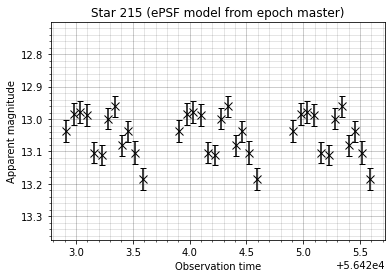

Variance: 0.004781863013152378
Mean square successive difference: 0.005179635210113595
Variability index: 0.9232045924422363


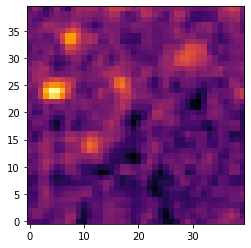

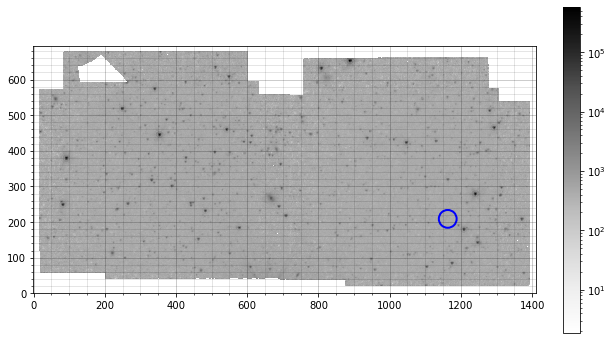

In [198]:
if method == 'aperture':
    load_name = 'phot_tables/huge_table_'+method+'_'+channel+'.pickle'
elif method == 'PSF':
    load_name = 'phot_tables/huge_table_'+method+'_'+channel+'_model_e'+str(model_epoch)+'.pickle'

pickle_in = open(load_name, 'rb')
huge_table = pickle.load(pickle_in)

cat_or_rand = 'rand'

if cat_or_rand == 'cat':
    ###   FOR PLOTTING STAR FROM CATALOGUE   ###
    
    file_CC = 'data/reference/CVSGC_PAL5_readable.txt'
    df_CC = pd.read_csv(file_CC, sep=',', header=0)
    coord_CC = SkyCoord(df_CC['RA'], df_CC['dec'])
    c_comp = SkyCoord(huge_table['RA']*u.degree, huge_table['dec']*u.degree)

    desired_star = 4
    # note: 0,2,4 only ones visible in channel 1
    c_CC = coord_CC[desired_star]
    print(c_CC)

    P = df_CC['period'][desired_star]
    temp = [i / P for i in LC_time]
    phase = temp - np.floor(temp)

    star_id, d2d, d3d = c_CC.match_to_catalog_sky(c_comp)
    print('Star ID: ', star_id)
    
else:
    ###   FOR PLOTTING RANDOM STAR IN TABLE   ###

    star_id = random.randint(0,len(huge_table))
    #star_id = 744
    print('Star ID: ', star_id)
    phase = LC_time


huge_table_f = copy.copy(huge_table.filled(-99))

mags = []
errs = []
for i in range(1,13):
    mags.append(huge_table_f['mag_e'+str(i)][star_id])
    errs.append(huge_table_f['err_e'+str(i)][star_id])

mags = np.ma.array(mags)
mags = np.ma.masked_where(mags == -99, mags)
errs = np.ma.array(errs)
errs = np.ma.masked_where(errs == -99, errs)
phase = np.ma.masked_array(phase, mags.mask)
print('Mags: ', mags)
print('Errs: ', errs)
print('Phase: ', phase)

mags_long = np.concatenate((mags, mags, mags))  # this idea taken from some of vicky's code; credit?
errs_long = np.concatenate((errs, errs, errs))
phase_long = np.concatenate((phase, phase + 1., phase + 2.))


plt.errorbar(phase_long, mags_long, yerr=errs_long, fmt='x', color='black', capsize=3, markersize=8)
plt.ylim(np.nanmedian(mags) - 1.5*(max(mags)-min(mags)), np.nanmedian(mags) + 1.5*(max(mags)-min(mags)))
#plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
if cat_or_rand == 'cat':
    plt.xlabel('Phase')
else:
    plt.xlabel('Observation time')
plt.ylabel('Apparent magnitude')
plt.title('Star '+str(star_id)+' (ePSF model from epoch '+str(model_epoch)+')')
plt.savefig('images/curves/'+method+'_'+channel+'_'+str(star_id)+'_'+str(model_epoch)+'.png', dpi=100)
plt.show()

###   VARIABILITY INDEX   ###

var = sum((m - np.mean(mags.compressed()))**2 for m in mags.compressed()) / (len(mags.compressed()) - 1)

diff = 0
for i in range(len(mags.compressed()) - 1):
    diff += (mags.compressed()[i+1] - mags.compressed()[i])**2
mssd = diff / (len(mags.compressed()) - 1)

eta_inv = var / mssd
print('Variance: {0}\nMean square successive difference: {1}\nVariability index: {2}'.format(var, mssd, eta_inv))

###   PLOTTING IMAGE OF STAR FROM MASTER FRAME   ###

star_r = 20
star_x = int(huge_table['xcentroid'][star_id])
star_y = int(huge_table['ycentroid'][star_id])
star_ap = CircularAperture((star_x, star_y), r=25.)

region = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
#star_ap.plot(color='white')
plt.show()

plt.imshow(data_m, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')
star_ap.plot(color='blue', lw=2.)
plt.colorbar(fraction = 0.05)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

#plotting(data_m, star_ap, an=None, cmap='Greys', choice='ap_only', savename=None)

In [71]:
huge_table[star_id:star_id+5]

<Table length=3>
id_master xcentroid ycentroid     RA    ... err_e11  mag_e12    err_e12  
  int32    float64   float64   float64  ... float64  float64    float64  
--------- --------- --------- --------- ... ------- --------- -----------
      787 227.48558 672.06251 228.98521 ...      --        --          --
      788 433.93674 672.31468 228.97961 ...     nan 15.672547 0.041171782
      789 281.87187 675.39181  228.9832 ...      --        --          --

In [25]:
#transf_list[300:350]
PSF_table['id', 'x_fit', 'y_fit', 'RA', 'dec', 'apparent_mag', 'mag_err'].show_in_notebook()

In [59]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def find_nearest_2d(ra, dec, ra_match, dec_match):
    idx_ra = (np.abs(ra - ra_match)).argmin()
    idx_dec = (np.abs(dec - dec_match)).argmin()
    
    return ra[idx_ra], dec[idx_dec], idx_ra, idx_dec

In [27]:
result, where = find_nearest(comp_table['RA'], 229.0045)
print(where, result)

357 229.00459461684292


In [58]:
minimum = comp_table['RA'].argmin()

print(minimum, comp_table[:][minimum])
print(comp_table['id', 'RA'][490:510])

557  id      xcenter            ycenter        aperture_sum_0  aperture_sum_1   bkg_sum_median     star_bkgsub        counts_err        apparent_mag         mag_err               RA                 dec         
           pix                pix                                                                                                                                                                             
--- ------------------ ----------------- ----------------- -------------- ----------------- ----------------- ------------------ ----------------- ------------------- ------------------ --------------------
558 1195.5269509660832 645.1245356312601 8931.419148989029            nan 4599.439769875287 4331.979379113742 483.18538531374304 16.47763681773167 0.12465424135017021 228.96346608124824 -0.12777725265088366
 id         RA        
--- ------------------
491 228.98377981844365
492 229.00425843676322
493 228.99521935321016
494  229.0027375581146
495  228.9854985754032
496 229

In [ ]:
start = time.perf_counter()
for a, c in phot_table.iterrows('id', 'xcenter'):
    print(a, c.value)
print('Time taken for iterrows: {}s'.format(time.perf_counter() - start))

In [ ]:
start = time.perf_counter()
for row in phot_table:
    print(row['id'], row['xcenter'].value)
print('Time taken for row in table: {}s'.format(time.perf_counter() - start))

In [ ]:
start = time.perf_counter()
for i in range(len(phot_table)):
    print(phot_table['id'][i], phot_table['xcenter'][i].value)
print('Time taken for shit method: {}s'.format(time.perf_counter() - start))

In [12]:
n = 500
sum = 0
while True:
    sum += n
    n = n - 1
    print(n, sum)
    if n == 0:
        break

499 500
498 999
497 1497
496 1994
495 2490
494 2985
493 3479
492 3972
491 4464
490 4955
489 5445
488 5934
487 6422
486 6909
485 7395
484 7880
483 8364
482 8847
481 9329
480 9810
479 10290
478 10769
477 11247
476 11724
475 12200
474 12675
473 13149
472 13622
471 14094
470 14565
469 15035
468 15504
467 15972
466 16439
465 16905
464 17370
463 17834
462 18297
461 18759
460 19220
459 19680
458 20139
457 20597
456 21054
455 21510
454 21965
453 22419
452 22872
451 23324
450 23775
449 24225
448 24674
447 25122
446 25569
445 26015
444 26460
443 26904
442 27347
441 27789
440 28230
439 28670
438 29109
437 29547
436 29984
435 30420
434 30855
433 31289
432 31722
431 32154
430 32585
429 33015
428 33444
427 33872
426 34299
425 34725
424 35150
423 35574
422 35997
421 36419
420 36840
419 37260
418 37679
417 38097
416 38514
415 38930
414 39345
413 39759
412 40172
411 40584
410 40995
409 41405
408 41814
407 42222
406 42629
405 43035
404 43440
403 43844
402 44247
401 44649
400 45050
399 45450
398 45849
39

In [16]:
sources_m
#phot_table

<Table length=790>
id_master xcentroid ycentroid ...     mag          RA         dec     
  int32    float64   float64  ...   float64     float64     float64   
--------- --------- --------- ... ------------ --------- -------------
        1 1269.5063 28.576869 ...   -1.1949248 229.06303   -0.15644268
        2  1140.274 29.994286 ...   -1.3635888 229.06627   -0.13514762
        3 1302.5324 30.413832 ...   -1.9032382 229.06184   -0.16182562
        4 799.68632 39.347906 ...   -1.5587134 229.07389  -0.078874023
        5 1264.2162 40.472713 ...   -0.8145772 229.06122   -0.15525266
        6 1152.0517 42.328688 ...   -2.8821654 229.06393   -0.13675324
        7 598.67352 42.873694 ...   -1.8614803 229.07872  -0.045715294
        8  388.5644 44.404782 ...   -4.4444334 229.08412  -0.011113989
        9  434.8194 45.885364 ...   -3.0165561 229.08263  -0.018682505
       10 1344.9425 46.565421 ...   -3.4093215 229.05804   -0.16836721
      ...       ...       ... ...          ...       ...           ...
      781 370.67854 659.79144 ...   -1.0932205 228.98337  0.0083750182
      782 409.67305 662.58407 ...   -0.5947858 228.98187  0.0020360395
      783 250.56652 664.24071 ...  -0.48573984 228.98587   0.028251448
      784 420.09073 664.23632 ...   -1.7676893 228.98131 0.00036689809
      785 282.89911 665.05082 ...  -0.90352564 228.98487   0.022954961
      786 457.36822 668.86272 ... -0.061010626 228.97955 -0.0056403471
      787 471.98503 669.64238 ...  -0.36293853 228.97903 -0.0080236518
      788 227.48558 672.06251 ... -0.075469756 228.98521   0.032258265
      789 433.93674 672.31468 ...   -3.0077181 228.97961 -0.0016933652
      790 281.87187 675.39181 ... -0.032319346  228.9832   0.023401984

In [171]:
huge_table

<Table length=790>
id_master xcentroid ycentroid     RA    ...   err_e11    mag_e12    err_e12  
  int32    float64   float64   float64  ...   float64    float64    float64  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1269.5063 28.576869 229.06303 ... 0.055731415        --          --
        1  1140.274 29.994286 229.06627 ... 0.054105766  17.05542 0.069173593
        2 1302.5324 30.413832 229.06184 ... 0.073385224 16.150355 0.076773955
        3 799.68632 39.347906 229.07389 ... 0.053338677 16.611629 0.050725526
        4 1264.2162 40.472713 229.06122 ...          --        --          --
        5 1152.0517 42.328688 229.06393 ... 0.039491488 15.412261 0.041721785
        6 598.67352 42.873694 229.07872 ...          -- 16.673805   0.0437395
        7  388.5644 44.404782 229.08412 ...          -- 14.239696 0.047796873
        8  434.8194 45.885364 229.08263 ...  0.03750833 15.351644 0.045831776
        9 1344.9425 46.565421 229.05804 ... 0.044553797 14.946782 0.040286809
      ...       ...       ...       ... ...         ...       ...         ...
      780 370.67854 659.79144 228.98337 ...          --        --          --
      781 409.67305 662.58407 228.98187 ...          --        --          --
      782 250.56652 664.24071 228.98587 ...          --        --          --
      783 420.09073 664.23632 228.98131 ...          -- 16.758244 0.050871738
      784 282.89911 665.05082 228.98487 ... 0.082312953        --          --
      785 457.36822 668.86272 228.97955 ...          --        --          --
      786 471.98503 669.64238 228.97903 ...          --        --          --
      787 227.48558 672.06251 228.98521 ...          --        --          --
      788 433.93674 672.31468 228.97961 ...  0.04141202 15.728745  0.04417744
      789 281.87187 675.39181  228.9832 ...          --        --          --

In [131]:
df_CC

ID            RA           dec units  period  mean_magnitude  amplitude  \
0   1  15h15m57.18s  -00d06m53.3s    R0  0.2932           17.71       0.42   
1   2  15h15m57.95s  -00d11m23.4s    R0  0.3325           17.81       0.40   
2   3  15h16m12.76s  -00d10m03.3s    R0  0.3300           17.70       0.50   
3   4  15h16m05.79s  -00d11m12.7s    R0  0.2864           17.69       0.48   
4   5  15h15m58.23s  -00d05m47.4s    R0  0.2524           17.70       0.30   

  colour type  
0      B  RR1  
1      B  RR1  
2      B  RR1  
3      B  RR1  
4      B  RR1

In [167]:
huge_table[star_id-2:star_id+3]
#huge_table.pprint(max_lines=30, max_width=100)

<Table length=5>
id_master xcentroid ycentroid     RA    ...   err_e11    mag_e12    err_e12  
  int32    float64   float64   float64  ...   float64    float64    float64  
--------- --------- --------- --------- ... ----------- --------- -----------
      628 463.40551 510.84182 229.00538 ... 0.030925665 11.710151 0.031405203
      629 835.17987 510.80851 228.99539 ... 0.061289798 17.465979 0.046936335
      630  1094.739 510.74841 228.98842 ... 0.040122819  16.33653 0.039601952
      631 102.37221  511.9406 229.01491 ...          -- 17.333198  0.05869642
      632  262.1968 511.67513 229.01065 ... 0.042355775 17.224051 0.043105278

[17.746219662205103, 17.52811363958394, 17.59565314449673, 17.602023724307283, 17.528880880727705, masked, 17.473908716684225, 17.240435977592952, 17.622627941527668, masked, masked, masked] [0.4212881844678604, 0.28039701660772653, 0.2822214873327525, 0.2745511500665917, 0.2684827732786732, masked, 0.2725105568300287, 0.13651345059880438, 0.15739104339528517, masked, masked, masked]


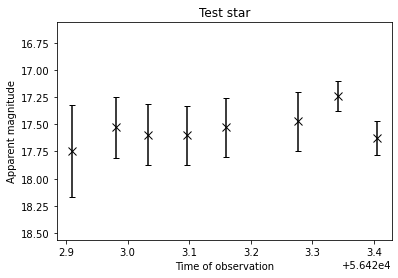

In [70]:
#match_table
#comp_table

#print(huge_table['mag_e1']['id_master' == 405])

star_id = 416
mags = []
errs = []
for i in range(1,13):
    mags.append(huge_table['mag_e'+str(i)][star_id-1])
    errs.append(huge_table['err_e'+str(i)][star_id-1])
    
print(mags, errs)

plt.errorbar(LC_time, mags, yerr=errs, fmt='x', color='black', capsize=3, markersize=8)
plt.ylim(np.nanmedian(mags)-1., np.nanmedian(mags)+1.)
#plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.xlabel('Time of observation')
plt.ylabel('Apparent magnitude')
plt.title('Test star')
plt.show()

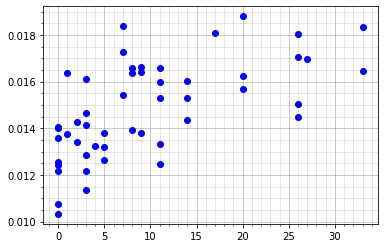

In [22]:
plt.plot(plot_id, plot_sep, 'bo')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')

In [26]:
comp_table_new.show_in_notebook()

In [28]:
match_table.show_in_notebook()

In [5]:
LC_time = []
for filename in glob.glob(base_dir+'*/PAL5__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/PAL5__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        print(filename)
        hdr = hdu_list[0].header
    
    LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)
    
print((LC_time))

data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
data/PAL5\PAL5__e2\PAL5__e2_3p6um.fits
data/PAL5\PAL5__e3\PAL5__e3_3p6um.fits
data/PAL5\PAL5__e4\PAL5__e4_3p6um.fits
data/PAL5\PAL5__e5\PAL5__e5_3p6um.fits
data/PAL5\PAL5__e6\PAL5__e6_3p6um.fits
data/PAL5\PAL5__e7\PAL5__e7_3p6um.fits
data/PAL5\PAL5__e8\PAL5__e8_3p6um.fits
data/PAL5\PAL5__e9\PAL5__e9_3p6um.fits
data/PAL5\PAL5__e10\PAL5__e10_3p6um.fits
data/PAL5\PAL5__e11\PAL5__e11_3p6um.fits
data/PAL5\PAL5__e12\PAL5__e12_3p6um.fits
[56422.909763090276, 56422.98037792824, 56423.03359486111, 56423.096869479166, 56423.158750648145, 56423.225721724535, 56423.277202604164, 56423.34184263889, 56423.403988252314, 56423.45839726852, 56423.51922112268, 56423.588995798615]


#### Light curves using PSF photometry:

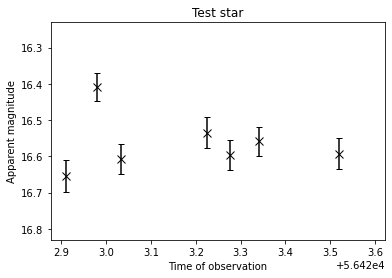

[0.30069267 0.54153454 0.72303841 0.93884543 0.14989989 0.3783142
 0.55389701 0.77436098 0.98631737 0.171887   0.37933534 0.61731173]


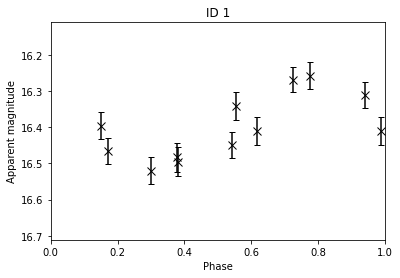

[0.9616935  0.17406896 0.33411988 0.52441949 0.71052827 0.91194504
 0.06677475 0.26118087 0.44808497 0.61172111 0.79464999 0.00449864]


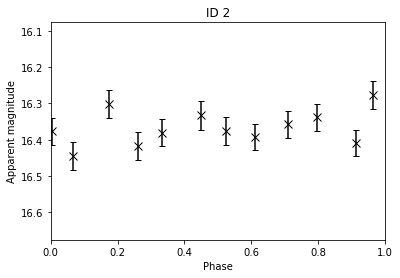

[0.51443361 0.72841796 0.8896814  0.08142266 0.26894136 0.47188401
 0.62788668 0.82376557 0.01208561 0.17696142 0.36127613 0.57271454]


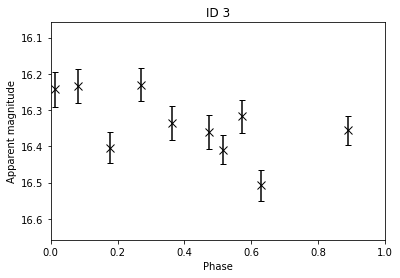

[0.36649124 0.61305143 0.79886474 0.01979567 0.2358612  0.46969876
 0.64945043 0.87514888 0.09213775 0.28211337 0.49448716 0.73811382]


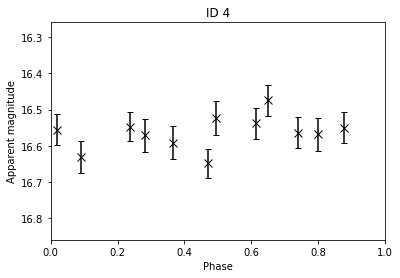

[0.60128007 0.8810536  0.09189723 0.34258906 0.5877601  0.85309717
 0.05706262 0.31316418 0.55938293 0.77494956 0.01593155 0.29237638]


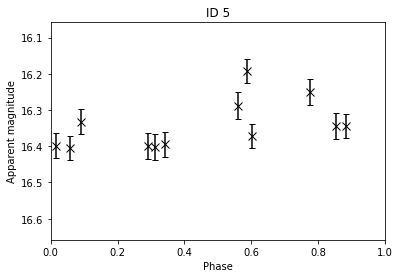

In [7]:
# in both channels (plotting 3.6):
mags0 = [16.519677555351063, 16.448904785279918, 16.26857607567118, 16.310895898080638, 16.395525901041232, 16.483376359834644, 16.340792692157947, 16.257803948885236, 16.410626392420863, 16.46537908621455, 16.495817514276617, 16.41100273178538]
errs0 = [0.03713640206365603, 0.03613446393076298, 0.035625961756734166, 0.0356783865260235, 0.037334189172879506, 0.04084857403466515, 0.03884690049150518, 0.037296951080817584, 0.03811393078316186, 0.03617252726251993, 0.03973058220433944, 0.0392854063685029]
P0 = 0.2932
temp0 = [i / P0 for i in LC_time]
phase0 = temp0 - np.floor(temp0)

# in 4.5:
mags1 = [16.277672910656825, 16.301333180848943, 16.380888441391054, 16.375096585365412, 16.356912130518303, 16.40985979328298, 16.445015859034083, 16.417067644270027, 16.333127585177465, 16.392408750201863, 16.337959227356464, 16.377194012491348]
errs1 = [0.03873324785761392, 0.03972692996329998, 0.037211411469618455, 0.039150852313629594, 0.03707645282599403, 0.03608124944279567, 0.0385347712454156, 0.03899284984059869, 0.038951580825702097, 0.03706771673969662, 0.03790340134585638, 0.03785672807306427]
P1 = 0.3325
temp1 = [i / P1 for i in LC_time]
phase1 = temp1 - np.floor(temp1)

# in both (plotting 3.6):
mags2 = [16.40916575815892, 99., 16.35570276890885, 16.234333159846145, 16.22992923566517, 16.3600506248805, 16.507522040514946, 99., 16.242687261640487, 16.404070665085783, 16.334982375416615, 16.316782892982452]
errs2 = [0.03927433972041632, 0.99, 0.04058008850636711, 0.04674092465694794, 0.045795802191035705, 0.0464220466963745, 0.042160964623426375, 0.99, 0.04834294503011385, 0.042787158206893, 0.046687528591144806, 0.04565376246358079]
P2 = 0.3300
temp2 = [i / P2 for i in LC_time]
phase2 = temp2 - np.floor(temp2)

# in 4.5:
mags3 = [16.591068420316713, 16.537575470354138, 16.567954478587957, 16.555134662063978, 16.54691895238257, 16.64845808279691, 16.474567658915756, 16.550841468949674, 16.630844366097023, 16.571254494272523, 16.52324681297703, 16.563704752491628]
errs3 = [0.045839076661486046, 0.042984751322457826, 0.04515255299450327, 0.043711633218924434, 0.03902275320420496, 0.040967714969965985, 0.04298494847352375, 0.042838660369016575, 0.04323567489560489, 0.04616755853947751, 0.04666409916143636, 0.043064113411362084]
P3 = 0.2864
temp3 = [i / P3 for i in LC_time]
phase3 = temp3 - np.floor(temp3)

# in both (plotting 3.6):
mags4 = [16.371372996593475, 16.343441163503417, 16.332575928694734, 16.395136667977027, 16.191765808662083, 16.344868367412346, 16.40489110945257, 16.4016908097425, 16.28783305230337, 16.249877734315376, 16.39838602338339, 16.400128300086692]
errs4 = [0.033386618945126526, 0.032537991227454814, 0.03428002405987278, 0.035538096598455464, 0.03259044213007228, 0.03633162973008966, 0.0331001027786394, 0.03493654675498968, 0.036316458841625224, 0.03506480855287536, 0.03454063489882175, 0.0354519433132128]
P4 = 0.2524
temp4 = [i / P4 for i in LC_time]
phase4 = temp4 - np.floor(temp4)

# random comparison star (229.0520356, -0.040969):
mags5 = [16.654094978311324, 16.408475227072014, 16.60671760315718, 99., 99., 16.534500180685495, 16.595721065212786, 16.558503582204676, 99., 99., 16.59316630763614, 99.]
errs5 = [0.043067212927277214, 0.03858500874159987, 0.04119255596289857, 0.99, 0.99, 0.0437626631614721, 0.041793804167100705, 0.039914724082824635, 0.99, 0.99, 0.04240129363803707, 0.99]

plt.errorbar(LC_time, mags5, yerr=errs5, fmt='x', color='black', capsize=3, markersize=8)
plt.ylim(np.median(mags5)-0.4, np.median(mags5)+0.2)
#plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.xlabel('Time of observation')
plt.ylabel('Apparent magnitude')
plt.title('Test star')
plt.show()

# which are we plotting?
mags = [mags0, mags1, mags2, mags3, mags4]
errs = [errs0, errs1, errs2, errs3, errs4]
phase = [phase0, phase1, phase2, phase3, phase4]

for i in range(5):
    print(phase[i])
    plt.errorbar(phase[i], mags[i], yerr=errs[i], fmt='x', color='black', capsize=3, markersize=8)
    plt.ylim(np.median(mags[i])-0.3, np.median(mags[i])+0.3)
    plt.xlim(0, 1)
    plt.gca().invert_yaxis()
    plt.xlabel('Phase')
    plt.ylabel('Apparent magnitude')
    plt.title('ID {}'.format(i+1))
    plt.show()

#### Light curves using aperture photometry:

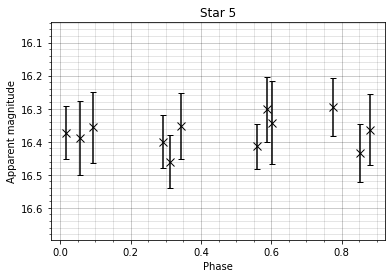

In [140]:
# in both channels (plotting 3.6):
mags0 = [16.43157778433534, 16.319314441774146, 16.21354352704053, 16.327590487062135, 16.317746028704423, 16.34900569826709, 16.343230972122385, 16.30785824226683, 16.377045582800523, 16.44130289138004, 16.415500323249354, 16.287110753513275]
errs0 = [0.13838664598827952, 0.10780331067171582, 0.09486667253241762, 0.1016663463776075, 0.10063442317573802, 0.08611479564282772, 0.11063234531058404, 0.07417571275191434, 0.06259481088703378, 0.09893399451334185, 0.08456608807642316, 0.07574819295316605]
# in 4.5:
mags1 = [16.349697786839492, 16.194217021173294, 16.207005959903483, 16.23294405138138, 16.1430420816718, 16.12791686426742, 16.26837437978528, 16.324855982183802, 16.232072215644155, 16.157475025652552, 16.25138566316509, 16.166943555086327]
errs1 = [0.17958778152037858, 0.1433238123772328, 0.146959995639462, 0.14113591767777456, 0.12881879914789937, 0.12940029159417565, 0.1517507389203297, 0.1622884911783416, 0.1418559107329996, 0.1291646825694402, 0.1417444816320583, 0.13079254157930084]
# in both (plotting 3.6):
mags2 = [16.507121898624785, 99., 16.594031065156816, 16.471979283826737, 16.5506588888354, 16.663817971344685, 16.653305561809617, 99., 16.32284697607006, 16.60503508571675, 16.37413120759308, 16.63518417065389]
errs2 = [0.17383252222681994, 0.99, 0.15655975055305543, 0.13654089165998548, 0.14133583501697225, 0.15108210857012513, 0.15994274878088585, 0.99, 0.08184423367559984, 0.1487957752353808, 0.09849007627864122, 0.13144182805275845]
# in 4.5:
mags3 = [16.497130434708644, 16.45681961736284, 16.497200920604453, 16.54585889371922, 16.53254265436601, 16.538997118835653, 16.506027786665513, 16.459382685891256, 16.625014892855898, 16.525223907640875, 16.546076172842064, 16.532152988639076]
errs3 = [0.20110724344935457, 0.19633938161381514, 0.1996158664764408, 0.20595281786428996, 0.20685299405385485, 0.1969220253200218, 0.20065585416811574, 0.18890188859798862, 0.21133575515138409, 0.19235670729902843, 0.19279003388946514, 0.19115887380519692]
# in both (plotting 3.6):
mags4 = [16.341757883504528, 16.363346683880508, 16.356868998845314, 16.352587784735846, 16.301941781453646, 16.43447125230149, 16.38766118029609, 16.46038054986956, 16.41409560418427, 16.29592913306142, 16.372069644250296, 16.399598524207565]
errs4 = [0.12490531888600374, 0.10726810792787739, 0.1079286445580241, 0.10071449872458513, 0.0986811049570592, 0.08865384931581587, 0.11215511874315458, 0.08026159600643352, 0.0681620353316304, 0.08788980946784694, 0.08090984170752949, 0.08102545988918496]
P4 = 0.2524
temp4 = [i / P4 for i in LC_time]
phase4 = temp4 - np.floor(temp4)

#print(LC_time)

# which are we plotting?
mags = mags4
errs = errs4
phase = phase4

plt.errorbar(phase, mags, yerr=errs, fmt='x', color='black', capsize=3, markersize=8)
plt.ylim(np.nanmedian(mags) - 2*(max(mags)-min(mags)), np.nanmedian(mags) + 2*(max(mags)-min(mags)))
#plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.xlabel('Phase')
plt.ylabel('Apparent magnitude')
plt.title('Star 5')
plt.show()

In [58]:
print(LC_time)

[56422.909763090276, 56422.98037792824, 56423.03359486111, 56423.096869479166, 56423.158750648145, 56423.225721724535, 56423.277202604164, 56423.34184263889, 56423.403988252314, 56423.45839726852, 56423.51922112268, 56423.588995798615]


Text(0, 0.5, 'Apparent magnitude')

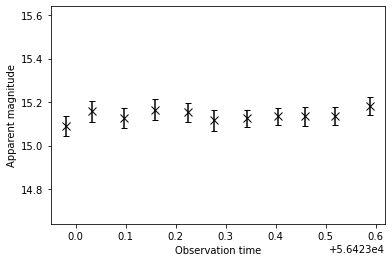

In [48]:
mags = [15.135318, 15.091023, 15.157274, 15.125232, 15.165279, 15.153156, 15.115333, 15.12553, 15.134397, 15.133601, 15.134529, 15.182143]
errs = [0.052111844, 0.045727061, 0.048106274, 0.045965951, 0.048540872, 0.043164507, 0.049312448, 0.038372559, 0.038525305, 0.043983157, 0.04061274, 0.043236986]

#plt.plot(LC_time, mags[1:12], 'bx')
plt.errorbar(LC_time, mags[1:12], yerr=errs[1:12], fmt='x', color='black', capsize=3, markersize=8)
plt.ylim(15.14-0.5, 15.14+0.5)
plt.xlabel('Observation time')
plt.ylabel('Apparent magnitude')

In [36]:
inyago = np.array(range(11, 17))
print(inyago)
testy = Table()
testy['id'] = inyago
print(testy)

print(len(x_model), len(y_model))

[11 12 13 14 15 16]
 id
---
 11
 12
 13
 14
 15
 16
71 71


In [36]:
print(np.nanmedian(PSF_table['mag_err']))
print(np.nanmedian(PSF_table_fixed['mag_err_fixed']))

0.05314430120091462
0.06610679478322196


In [ ]:
print(fitted_stars.center_flat)

In [ ]:
nddata = NDData(data = data - median)
        model_stars = extract_stars(nddata, model_table, size=25)
        print('Number of model stars: {}'.format(len(model_stars)))
        nrows = 5
        ncols = 5
        fig, ax = plt.subplots(nrows, ncols, figsize=(15,15), squeeze=True)
        ax = ax.ravel()
        
        for i in range(nrows * ncols):
            norm = simple_norm(model_stars[i], 'log', percent=99.)
            ax[i].imshow(model_stars[i], norm=norm, origin='lower', cmap='inferno')
        plt.show()

In [ ]:
phot['apparent_mag_err'][i] = pow(zmag_err^2 + (2.5*(phot['bkgsub_flux_err'][i]^2 + ap_err^2)^0.5 / (aper_corr * phot['apparent_mag'][i] * np.log(10))), 0.5)

In [26]:
np.fabs(-34)

34.0

#### Version that matches all epochs to epoch 1 (hard to find those that appear in all though):
## UNFINISHED (abandoned?)

In [ ]:
print('Photometry method selected: {}'.format(method))

###   INITIALISING IMAGE WE'LL BE COMPARING OTHER EPOCHS TO WHEN STAR MATCHING   ###

comp_epoch = 1  # epoch to compare all others against when matching stars   
epoch = 1  # counter to be incremented every epoch
LC_mag = []
LC_err = []
LC_time = []

for filename in glob.glob(base_dir+'*/PAL5__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/PAL5__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    
    ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###
    
    with fits.open(filename) as hdu_list:        
        print(filename)
        image_data = hdu_list[0].data
        hdr = hdu_list[0].header
        exptime = hdr['EXPTIME']
        fluxconv = hdr['FLUXCONV']
        conv = exptime / fluxconv
        print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
        data = image_data * conv
    
    file_corr = base_dir+'PAL5__e'+str(epoch)+'/PAL5__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(file_corr) as hdu_list:
        data_corr = hdu_list[0].data
        
    mean, median, std = sigma_clipped_stats(data, sigma=sigma_level)
    print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))
    
    if method == 'aperture':
    
        ###   LOCATING STARS AND PLOTTING THEM   ###
        # could maybe put most of this in its own starfind function? including aperture and position bits

        sources = star_find(data, sigma_level, FWHM, std, roundness, sharphi)
        #sources = star_find(data, 300., FWHM, std, roundness, sharphi)
        pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(pos, r_ap)
        annuli = CircularAnnulus(pos, r_in, r_out)
        print('No. of stars detected: {0}'.format(len(sources)))
        plotting(data, apertures, annuli, 'Greys', choice='both_aps', savename=None)
        
        #starlist = np.array(sources['xcentroid', 'ycentroid'])
        #np.savetxt('outputs/starlist_02.txt', starlist, delimiter=',')

        ###   DOING APERTURE PHOTOMETRY   ###

        phot_table = ap_phot(data, apertures, annuli, 'median')
        
        phot_table['apparent_mag'] = float('NaN')
        phot_table['mag_err'] = float('NaN')
        for i in range(len(phot_table)):
            locorr = data_corr[int(phot_table['ycenter'][i].value)][int(phot_table['xcenter'][i].value)]  # location-dependent correction at star's location
            if phot_table['star_bkgsub'][i] >= 0:
                phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)
        
        phot_table.write('outputs/table_e'+str(epoch)+'_'+channel+'.txt', format='csv', overwrite=True)
        #print_table_nicely(phot_table)
        print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])
        
        ###   STAR MATCHING   ###
        
        if epoch == comp_epoch:  # this may only work in this format if comp_epoch = 1 lol
            comp_table = copy.copy(phot_table)
            cat_comp, ra_comp, dec_comp = make_catalog(comp_table['xcenter'], comp_table['ycenter'], hdr)
            comp_table['RA'] = ra_comp
            comp_table['dec'] = dec_comp
        else:
            match_table = copy.copy(phot_table)
            cat_match, ra, dec = make_catalog(match_table['xcenter'], match_table['ycenter'], hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec
            
            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_comp)

            # Selection criteria:
            max_sep = 0.25 * u.arcsec
            selection = (d2d > max_sep)
            match_index = idx
            match_index[selection] = -99.
            ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)
            print('Number of common stars:', sum(ind))

            match_table = match_table[ind]
            comp_table_new = comp_table[match_index][ind]  # creating a different object so comp_table is untouched for the next iteration
            delta_mag = comp_table_new['apparent_mag'] - match_table['apparent_mag']
            print_table_nicely(match_table)
            print_table_nicely(comp_table_new)

            plt.plot(delta_mag, match_table['apparent_mag'], 'b+')
            #plt.plot(delta_mag, mag1, 'b+')
            plt.xlabel('Difference in magnitude between epochs')
            plt.ylabel('Magnitude')
            plt.grid()
            plt.gca().invert_yaxis()
            plt.gcf().set_size_inches(10, 8)
            plt.show()
            
            #LC_mag.append(match_table['apparent_mag'][0])  # doesn't currently include first epoch mag
        
    
    elif method == 'PSF':
        
        ###   DETECTING MORE STARS   ###
        
        daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=0.85)
        sources_PSF = daofind_PSF(data)
        
        #sources_PSF = star_find(data, sigma_level, FWHM, std, roundness, sharphi)
        pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
        ap_PSF = CircularAperture(pos_PSF, r_ap)
        plotting(data, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename='psf_detect_test_00.png')
        print('Number of PSF stars: {}'.format(len(sources_PSF)))
        
        ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###
        
        sources_PSF['xcentroid'].name = 'x_0'
        sources_PSF['ycentroid'].name = 'y_0'
        daogroup = DAOGroup(crit_separation=2.5*FWHM)
        star_groups = daogroup(sources_PSF)
        star_groups = star_groups.group_by('group_id')
        print_table_nicely(star_groups)
        
        ncolors = max(star_groups['group_id'])
        cmap = make_random_cmap(ncolors=ncolors, seed=1612)
        plt.imshow(data, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
        for i, group in enumerate(star_groups.groups):
            pos_group = np.transpose([group['x_0'], group['y_0']])
            ap_group = CircularAperture(pos_group, r_ap)
            ap_group.plot(color=cmap.colors[i], lw=1.)
        plt.gcf().set_size_inches(15, 9)
        plt.show()
        
        ###   DOING PSF PHOTOMETRY   ###
        
        data_nonans = np.nan_to_num(data, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash
        
        #bkg_estimation = MMMBackground()
        #fitter = LevMarLSQFitter()
        fit_rad = 5
        
        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
        
        start = time.perf_counter()
        PSF_photometry = ISPSF(finder = daofind_PSF,
                              group_maker = daogroup,
                              bkg_estimator = MMMBackground(),
                              psf_model = epsf,
                              fitter = LevMarLSQFitter(),
                              fitshape = 2*fit_rad+1,
                              niters = 10,
                              aperture_radius = 6.)
        PSF_table = PSF_photometry(image=data_nonans, init_guesses=init_pos)
        residual_image = PSF_photometry.get_residual_image()
        print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))
        
        plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)
        
        PSF_table['apparent_mag'] = float('NaN')
        PSF_table['mag_err'] = float('NaN')
        for i in range(len(PSF_table)):
            locorr = data_corr[int(PSF_table['y_fit'][i])][int(PSF_table['x_fit'][i])]  # location-dependent correction at star's location
            if PSF_table['flux_fit'][i] >= 0:
                PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)
        
        print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])
        #PSF_table.write('outputs/'+method+'_'+channel+'_results_e'+str(epoch)+'.txt', format='csv', overwrite=True)
        
        
        
        #print_table_nicely(match_table['id_matched', 'id', 'RA', 'dec', 'apparent_mag', 'mag_err'])
        #print_table_nicely(comp_table['id_master', 'RA', 'dec'])

        #huge_table = Table()
        #huge_table['id'] = comp_table['id_master']
        #huge_table['x'] = comp_table['xcentroid']
        #huge_table['y'] = comp_table['ycentroid']
        #mag_name = 'apparent_mag_e'+str(epoch)
        #err_name = 'mag_err_e'+str(epoch)
        #huge_table[mag_name] = match_table['apparent_mag']
        #huge_table[err_name] = match_table['mag_err']

        #print_table_nicely(huge_table)

        #LC_mag.append(match_table['apparent_mag'][0])  # doesn't currently include first epoch mag

        #c1 = SkyCoord(match_table['RA'], match_table['dec'], frame='icrs', unit='deg')
        #c2 = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')
        #sep = c1.separation(c2)
        #print('Largest separation between matching RA and dec coords: {} arcsec'.format(max(sep.arcsecond)))


        #print('\n\n\n\n')
        #print('Source list:')
        #print_table_nicely(sources_m)
        #print('\nComp table:')
        #print_table_nicely(comp_table)
        #print('\nMatch table:')
        #print_table_nicely(match_table)
        #print('\nHuge table:')
        #print_table_nicely(huge_table)
        
    print('\n\n\n')
    
    if run_all == False:
        break
    
    #if epoch == 2:
    #    break
    
    epoch += 1

Photometry method selected: aperture
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
Mean: 44.65657043457031
Median: 43.07997131347656
Std dev: 15.755472183227539


No. of stars detected: 570


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


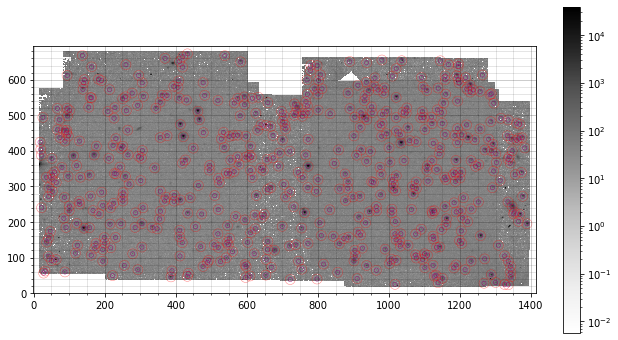

<ipython-input-5-e8aeac4c3523>:64: RuntimeWarning: invalid value encountered in sqrt
  poisson_err = np.sqrt(table['star_bkgsub'])


 id  xcenter   ycenter  star_bkgsub counts_err apparent_mag   mag_err  
       pix       pix                                                   
--- --------- --------- ----------- ---------- ------------ -----------
  1 1335.7201 23.327156         nan        nan          nan         nan
  2  1017.072 24.456139         nan        nan          nan         nan
  3 1325.4233 24.020858         nan        nan          nan         nan
  4 1267.5653 27.531396   2226.6141   767.3085    17.185296  0.37531789
  5 1138.3723 28.990912   3046.2008   534.0198    16.847198  0.19261651
  6  1300.237 29.593042   4230.9051  1068.2979    16.489141   0.2757345
  7 722.22393 37.943258         nan        nan          nan         nan
  8 797.63943 39.455565         nan        nan          nan         nan
  9 910.48561  40.64482   1653.9253  468.00082    17.525399  0.30864139
 10 1150.0528 41.601753   14732.661  582.48216    15.135318 0.052111844
...       ...       ...         ...        ...          ...     

In [21]:
print('Photometry method selected: {}'.format(method))

###   INITIALISING IMAGE WE'LL BE COMPARING OTHER EPOCHS TO WHEN STAR MATCHING   ###

comp_epoch = 1  # epoch to compare all others against when matching stars   
epoch = 1  # counter to be incremented every epoch
LC_mag = []
LC_err = []
LC_time = []

for filename in glob.glob(base_dir+'*/PAL5__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/PAL5__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    
    ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###
    
    with fits.open(filename) as hdu_list:        
        print(filename)
        image_data = hdu_list[0].data
        hdr = hdu_list[0].header
        exptime = hdr['EXPTIME']
        fluxconv = hdr['FLUXCONV']
        conv = exptime / fluxconv
        print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
        data = image_data * conv
    
    file_corr = base_dir+'PAL5__e'+str(epoch)+'/PAL5__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(file_corr) as hdu_list:
        data_corr = hdu_list[0].data
        
    mean, median, std = sigma_clipped_stats(data, sigma=sigma_level)
    print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))
    
    
    
    if method == 'aperture':
    
        ###   LOCATING STARS AND PLOTTING THEM   ###
        # could maybe put most of this in its own starfind function? including aperture and position bits

        sources = star_find(data, sigma_level, FWHM, std, roundness, sharphi)
        #sources = star_find(data, 300., FWHM, std, roundness, sharphi)
        pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(pos, r_ap)
        annuli = CircularAnnulus(pos, r_in, r_out)
        print('No. of stars detected: {0}'.format(len(sources)))
        plotting(data, apertures, annuli, 'Greys', choice='both_aps', savename=None)
        
        #starlist = np.array(sources['xcentroid', 'ycentroid'])
        #np.savetxt('outputs/starlist_02.txt', starlist, delimiter=',')

        ###   DOING APERTURE PHOTOMETRY   ###

        phot_table = ap_phot(data, apertures, annuli, 'median')
        
        phot_table['apparent_mag'] = float('NaN')
        phot_table['mag_err'] = float('NaN')
        for i in range(len(phot_table)):
            locorr = data_corr[int(phot_table['ycenter'][i].value)][int(phot_table['xcenter'][i].value)]  # location-dependent correction at star's location
            if phot_table['star_bkgsub'][i] >= 0:
                phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)
        
        phot_table.write('outputs/table_'+channel+'_e'+str(epoch)+'.txt', format='csv', overwrite=True)
        #print_table_nicely(phot_table)
        print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])
        
        ###   COMPARING AGAINST MASTER LIST   ###
        
        cat_ep, ra_ep, dec_ep = make_catalog(phot_table['xcenter'], phot_table['ycenter'], hdr)
        phot_table['RA'] = ra_ep
        phot_table['dec'] = dec_ep
        #seps = []
        plot_id = []
        plot_sep = []
        
        start = time.perf_counter()
        
        for ma in range(350, 400):
            seps = []
            for ep in range(350, 400):
                seps.append(cat_ep[ep].separation(cat_m[ma]).value)
            id_good = np.asarray(seps).argmin()

            print('Ma: {0}\tEp: {1}\tId: {2}\tSep: {3}'.format(ma, ep, id_good, seps[id_good]))
            plot_id.append(id_good)
            plot_sep.append(seps[id_good])
        
        
        # this is waaaay too slow over two massive tables :(
        # plus, how would i handle multiple epoch stars matching the same master star??
        
        
        print('Time taken to calculate all separations: {}s'.format(time.perf_counter() - start))
        print(len(seps))
        #print(seps)
        
        
        # NEXT STEP: 
            
        
        
        
        ###   STAR MATCHING   ###
        
        if star_matching == 'yes':
        
            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            if epoch == comp_epoch:  # this may only work in this format if comp_epoch = 1 lol
                comp_table = copy.copy(phot_table)
                cat_comp, ra_comp, dec_comp = make_catalog(comp_table['xcenter'], comp_table['ycenter'], hdr)
                comp_table['RA'] = ra_comp
                comp_table['dec'] = dec_comp

                comp_table['id', 'RA', 'dec', 'xcenter', 'ycenter', 'apparent_mag', 'mag_err'].write('outputs/comp_table_'+channel+'_e'+str(epoch)+'.txt', format='csv', overwrite=True, delimiter=' ')
            else:
                match_table = copy.copy(phot_table)
                cat_match, ra, dec = make_catalog(match_table['xcenter'], match_table['ycenter'], hdr, master)
                match_table['RA'] = ra
                match_table['dec'] = dec

                match_table['id', 'RA', 'dec', 'xcenter', 'ycenter', 'apparent_mag', 'mag_err'].write('outputs/match_table_'+channel+'_e'+str(epoch)+'.txt', format='csv', overwrite=True, delimiter=' ')

                idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_comp)

                # Selection criteria:
                max_sep = 0.25 * u.arcsec
                selection = (d2d > max_sep)
                match_index = idx
                match_index[selection] = -99.
                ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)
                print('Number of common stars:', sum(ind))

                match_table = match_table[ind]
                comp_table_new = comp_table[match_index][ind]  # creating a different object so comp_table is untouched for the next iteration
                delta_mag = comp_table_new['apparent_mag'] - match_table['apparent_mag']
                print_table_nicely(match_table['id', 'xcenter', 'ycenter', 'RA', 'dec', 'apparent_mag', 'mag_err'])
                print_table_nicely(comp_table_new['id', 'xcenter', 'ycenter', 'RA', 'dec', 'apparent_mag', 'mag_err'])

                plt.plot(delta_mag, match_table['apparent_mag'], 'b+')
                #plt.plot(delta_mag, mag1, 'b+')
                plt.xlabel('Difference in magnitude between epochs')
                plt.ylabel('Magnitude')
                plt.grid()
                plt.gca().invert_yaxis()
                plt.gcf().set_size_inches(10, 8)
                plt.show()

                #LC_mag.append(match_table['apparent_mag'][0])  # doesn't currently include first epoch mag

                c1 = SkyCoord(match_table['RA'], match_table['dec'], frame='icrs', unit='deg')
                c2 = SkyCoord(comp_table_new['RA'], comp_table_new['dec'], frame='icrs', unit='deg')
                sep = c1.separation(c2)
                print('Largest separation between matching RA and dec coords: {} arcsec'.format(max(sep.arcsecond)))
        
        
        
    
    elif method == 'PSF':
        
        ###   DETECTING MORE STARS   ###
        
        daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=0.85)
        sources_PSF = daofind_PSF(data)
        
        #sources_PSF = star_find(data, sigma_level, FWHM, std, roundness, sharphi)
        pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
        ap_PSF = CircularAperture(pos_PSF, r_ap)
        plotting(data, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename='psf_detect_test_00.png')
        print('Number of PSF stars: {}'.format(len(sources_PSF)))
        
        ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###
        
        sources_PSF['xcentroid'].name = 'x_0'
        sources_PSF['ycentroid'].name = 'y_0'
        daogroup = DAOGroup(crit_separation=2.5*FWHM)
        star_groups = daogroup(sources_PSF)
        star_groups = star_groups.group_by('group_id')
        print_table_nicely(star_groups)
        
        ncolors = max(star_groups['group_id'])
        cmap = make_random_cmap(ncolors=ncolors, seed=1612)
        plt.imshow(data, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
        for i, group in enumerate(star_groups.groups):
            pos_group = np.transpose([group['x_0'], group['y_0']])
            ap_group = CircularAperture(pos_group, r_ap)
            ap_group.plot(color=cmap.colors[i], lw=1.)
        plt.gcf().set_size_inches(15, 9)
        plt.show()
        
        ###   DOING PSF PHOTOMETRY   ###
        
        data_nonans = np.nan_to_num(data, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash
        
        #bkg_estimation = MMMBackground()
        #fitter = LevMarLSQFitter()
        fit_rad = 5
        
        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
        
        start = time.perf_counter()
        PSF_photometry = ISPSF(finder = daofind_PSF,
                              group_maker = daogroup,
                              bkg_estimator = MMMBackground(),
                              psf_model = epsf,
                              fitter = LevMarLSQFitter(),
                              fitshape = 2*fit_rad+1,
                              niters = 10,
                              aperture_radius = 6.)
        PSF_table = PSF_photometry(image=data_nonans, init_guesses=init_pos)
        residual_image = PSF_photometry.get_residual_image()
        print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))
        
        plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)
        
        PSF_table['apparent_mag'] = float('NaN')
        PSF_table['mag_err'] = float('NaN')
        for i in range(len(PSF_table)):
            locorr = data_corr[int(PSF_table['y_fit'][i])][int(PSF_table['x_fit'][i])]  # location-dependent correction at star's location
            if PSF_table['flux_fit'][i] >= 0:
                PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)
        
        
        cat, ra, dec = make_catalog(PSF_table['x_fit'], PSF_table['y_fit'], hdr)
        PSF_table['RA'] = ra
        PSF_table['dec'] = dec
        
        #print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])
        print_table_nicely(PSF_table['id', 'x_fit', 'y_fit', 'RA', 'dec', 'apparent_mag', 'mag_err'])
        PSF_table['id', 'RA', 'dec', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'].write('outputs/matching/'+method+'_'+channel+'_matching_e'+str(epoch)+'.txt', format='csv', overwrite=True, delimiter=' ')
        
        LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)
        
        
    print('\n\n\n')
    
    if run_all == False:
        break
    
    #if epoch == 2:
    #    break
    
    epoch += 1